<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <p style=" text-align: center; font-size: 32px;">   
   <strong>Pricing Parisian Options </strong></p>
    <p style=" text-align: center; font-size: 25px;"><strong> Master Probabilities & Finance - Ecole Polytechnique and Sorbonne University <strong></p>
  <p style=" text-align: center; font-size: 20px;"> Elias MBAREK, Constantin GLEYZE</p>
</header>


This notebook implements and compare three methods to price Parisan Options:
- A naive Monte Carlo approach,
- Brownian Bridge Monte Carlo approach,
- Laplace transform coupled with Euler summation for extremely fast numerical inversion of the Laplace transform. 

For the first two methods, we also added an adaptative anthitetic variance reduction algorithm to improve the convergence. 

> **The specific Laplace Method is from the following paper:**  
> Céline Labart, Jérôme Lelong. Pricing Parisian options using Laplace transforms. Bankers Markets
& Investors : an academic & professional review, 2009, 99, 24 p. ffhal-00776703


<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Import libraries</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [8]:
import numpy as np
import time
import pandas as pd 
from numba import njit, prange
import gc
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import display, HTML
from concurrent.futures import ThreadPoolExecutor
from scipy.special import erf
import random
from functools import partial
display(HTML("""
<style>
    .my-table th {
        text-align: center !important;
        vertical-align: middle !important;
    }
</style>
"""))

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Utility Functions</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [9]:
def print_pricing_data(labels, ts, n_paths, partial_delay, S0, K, T, L, vol, r, q,method):

    """
    Print pricing metrics and timing for various Monte Carlo and analytical methods.

    Parameters
    ----------
    labels: list of tuple of str
        Pairs of labels identifying payoff methods to compare.
    ts: array_like
        Time grid of the simulation.
    n_paths: int
        Number of Monte Carlo paths.
    partial_delay: float
        Fractional delay parameter for barrier monitoring.
    S0: float
        Initial asset price.
    K: float
        Option strike price.
    T: float
        Option maturity.
    L: float
        Barrier level for up-in/down-in options.
    vol: float
        Implied volatility.
    r: float
        Risk-free interest rate.
    q: float
        Dividend yield rate.
    method: callable
        Pricing function to invoke (e.g., Naive_MC_Pricing_function).

    Returns
    -------
    None
        Prints results; does not return a value.
    """

    # Map internal function names to human-readable method names
    method_to_name = {
    "Naive_MC_Pricing_function": "Naive MC",
    "Brownian_Bridge_Pricing_function": "Brownian Bridge",
    "Laplace_Pricing_function": "Laplace Method"
    }

    # Compute time step and integer delay from fractional delay
    dt = ts[1] - ts[0]
    delay = int(np.round(partial_delay * T / dt))
    print(f"\nPricing with {method_to_name[method.__name__]}: \n") # Convert fractional to integer delay

    # Header for current pricing method
    if method.__name__ == "Laplace_Pricing_function": 
        S1=0 # No path simulation required for Laplace method
        U=0 # No uniform variates needed
    else: 
        print(f"Number of paths, discretization    : ({n_paths}, {len(ts)})") # Display simulation dimensions

        # Generate Brownian increments W
        t0 = time.time()
        W = normal_random_simulation(ts, n_paths, S0, vol, r, q)
        print(f"Time - Generate W     : {time.time() - t0:.4f} sec") # Time to simulate W

        # Simulate asset paths S1
        t0 = time.time()
        S1 = get_paths_from_numba(ts, S0, vol, r, q, W)
        print(f"Time - Simulate S    : {time.time() - t0:.4f} sec")
        del W
        gc.collect()

        # Generate uniform variates for Brownian Bridge adjustments
        if method.__name__ == "Brownian_Bridge_Pricing_function": 
            t0 = time.time()
            U = np.random.rand(S1.shape[0] - 1, S1.shape[1]).astype(np.float32)
            print(f"Time - Simulate U    : {time.time() - t0:.4f} sec") # Time to compute S1
        else: 
            U=0

    # Loop over each pair of labels to compute payoffs and compare to Black-Scholes
    for (label_1, label_2) in labels :

        t1 = time.time()
        payoff_brut_1 = method (label_1, S1, S0, T, K, L, r, q, vol, delay, ts, n_paths,True, U)
        t1_2 = time.time()
        payoff_brut_2 = method (label_2, S1, S0, T, K, L, r, q, vol, delay, ts, n_paths,True, U)
        t2 = time.time()

        # Discounted prices and variances
        price_1, var_1 = np.exp(-r*T)*np.mean(payoff_brut_1), np.var(np.exp(-r*T)*(payoff_brut_1))
        price_2, var_2 = np.exp(-r*T)*np.mean(payoff_brut_2), np.var(np.exp(-r*T)*(payoff_brut_2))

        # Choose Black-Scholes formula based on option type (Put or Call)
        if label_1[-1] == "P": 
            t3 = time.time()
            BS_price = BS_put(S0, T, K, r, q, vol)
            t4 = time.time()
            label_BS = "Put"
        elif label_1[-1] == "C": 
            t3 = time.time()
            BS_price = BS_call(S0, T, K, r, q, vol)
            t4 = time.time()
            label_BS = "Call"
        else: 
            raise ValueError(f"Label {label_1} is not recognized for Call/Put assignment")

        # Print results: variances included except for Laplace method
        if method.__name__ == "Laplace_Pricing_Function": 
            print(f"\n{label_1}: {price_1:.6f} (time = {t1_2 - t1:.4f} sec)")
            print(f"{label_2}: {price_2:.6f} (time = {t2 - t1_2:.4f} sec)")
            print(f"{label_BS}: {BS_price:.6f} (time = {t4 - t3:.4f} sec)")
            print(f"Difference {label_1}+{label_2} - {label_BS} : {price_1+price_2-BS_price:.9f}")
        else: 
            print(f"\n{label_1}: {price_1:.6f} (var = {var_1:.3e}, time = {t1_2 - t1:.4f} sec)")
            print(f"{label_2}: {price_2:.6f} (var = {var_2:.3e}, time = {t2 - t1_2:.4f} sec)")
            print(f"{label_BS}: {BS_price:.6f} (time = {t4 - t3:.4f} sec)")
            print(f"Difference {label_1}+{label_2} - {label_BS}: {price_1+price_2-BS_price:.9f}")
    print("\n")
    if method.__name__ == "Brownian_Bridge_Pricing_function": 
        del U 
        gc.collect() # Clean up uniform variates
    del S1
    gc.collect() # Clean up simulated paths

In [10]:
def plot_results(label, ts, n_paths, delays, S0, K, T, L, vol, r, q,methods,brut_prices,plot_adaptative,CI, unique_price_simulation, proba=0.95):

    """
    Plots pricing results of a Parisian option for different delays with and without variance reduction.

    Notes
    -----
    - Generates paths once for each delay value.
    - Computes brut (raw) MC and adaptative antithetic MC prices.
    - Shows price with confidence intervals on the same graph.
    - Applies variance reduction techniques adaptatively on the second curve.

    Parameters
    ----------
    label: str
           Name of the option payoff (e.g., "PUIC").
    ts: array_like
        Array of simulation time steps.
    n_paths: int
             Number of simulated paths.
    delays: array_like
            Different delays to test (as fraction of T).
    S0: float
        Initial spot price.
    K: float
       Strike price.
    T: float
       Time to maturity.
    L: float
        Barrier level.
    vol: float
         Volatility of the underlying.
    r: float
       Risk-free interest rate.
    q: float
        Dividend yield.
    methods: list of callables
             Pricing functions to evaluate.
    brut_prices: bool
                 Whether to compute raw Monte Carlo prices.
    plot_adaptative: bool
                     Whether to compute adaptative antithetic prices.
    CI: bool
        Whether to include confidence intervals.
    unique_price_simulation: bool
                             Reuse one set of simulated paths for all delays.
    proba: float, optional
           Confidence level for intervals (default: 0.95).

    Returns
    -------
    None
        Displays a Matplotlib plot; returns nothing.
    """
    
    markers = ['o', 'x', '*', '+', '^', 's', 'D', 'v', '<', '>'] # Setup markers for each method curve

    # Precompute quantile for confidence intervals
    alpha = 1 - proba 
    quantile = stats.norm.ppf(1 - alpha/2) 
    
    dt = ts[1] - ts[0] # Time increment from grid

    # Color mappings for brut/adaptative and methods
    method_colors = {
    ("Naive_MC_Pricing_function", "brut"): "blue",
    ("Naive_MC_Pricing_function", "adaptative"): "orange",
    ("Brownian_Bridge_Pricing_function", "brut"): "green",
    ("Brownian_Bridge_Pricing_function", "adaptative"): "purple",
    ("Laplace_Pricing_function", "brut"): "red",
    }

    method_to_name = {
    "Naive_MC_Pricing_function": "Naive MC",
    "Brownian_Bridge_Pricing_function": "Brownian Bridge",
    "Laplace_Pricing_function": "Laplace Method"
    }

    # Fallback colors if mapping missing
    colors = list(plt.cm.tab10.colors)
    random.shuffle(colors)

    # Validate confidence interval setup
    if CI:
        assert brut_prices or plot_adaptative, "CI enabled but no pricing method selected to apply it to."

    # Allocate arrays for storing results
    if brut_prices: 
        prices_brut = np.empty((len(methods), len(delays)))
        if CI: 
            lower_bound_brut = np.empty((len(methods), len(delays)))
            upper_bound_brut = np.empty((len(methods), len(delays)))

    if plot_adaptative: 
        prices_adaptative = np.empty((len(methods), len(delays)))
        if CI: 
            upper_bound_adaptative = np.empty((len(methods), len(delays)))
            lower_bound_adaptative = np.empty((len(methods), len(delays)))
    discount = np.exp(-r*T)

    # If only Laplace, no simulation required
    if len(methods) == 1 and methods[0].__name__ == "Laplace_Pricing_function": 
        S1, U1 = 0,0
    else: 
        if unique_price_simulation: 
            # Simulate W, S1, and U1/U2 once for all delays
            W = normal_random_simulation(ts, n_paths, S0, vol, r, q) # Standard normals
            S1 = get_paths_from_numba(ts, S0, vol, r, q, W) # First simulation
            U1 = np.random.rand(S1.shape[0] - 1, S1.shape[1]).astype(np.float32) # For the Brownian Bridge approach
            if plot_adaptative: 
                S2 = get_paths_from_numba(ts, S0, vol, r, q, -W) # Antithetic simulation
                U2 = 1-U1
            del W
            gc.collect()
        
    # Loop over each delay value
    for idx_d, d in enumerate(delays):
        delay_steps = int(np.round(d * T / dt)) # Steps corresponding to delay
        for idx_method, method in enumerate(methods):

            # Handle Laplace method specially
            if methods[0].__name__ == "Laplace_Pricing_function":

                payoff_brut = method(label, 0, S0, T, K, L, r, q, vol, d, ts, n_paths, True, 0)
                price_brut = discount*np.mean(payoff_brut)

                if brut_prices: 
                    prices_brut[idx_method][idx_d] = price_brut
                    
                if plot_adaptative:
                    price_brut = discount*np.mean(payoff_brut)
                    prices_adaptative[idx_method][idx_d] = price_brut

            else: 

                # If not reusing simulation, regenerate for each delay
                if not unique_price_simulation:
                    W = normal_random_simulation(ts, n_paths, S0, vol, r, q) # Standard normals
                    S1 = get_paths_from_numba(ts, S0, vol, r, q, W) # First simulation
                    U1 = np.random.rand(S1.shape[0] - 1, S1.shape[1]).astype(np.float32) # For the Brownian Bridge approach
                    if plot_adaptative: 
                        S2 = get_paths_from_numba(ts, S0, vol, r, q, -W) # Antithetic simulation
                        U2 = 1-U1
                    del W
                    gc.collect() # Cleanup per-delay

                # Compute raw Monte Carlo price
                if brut_prices: 
                    payoff_brut = method(label, S1, S0, T, K, L, r, q, vol, delay_steps, ts, n_paths, True, U1)
                    price_brut = discount*np.mean(payoff_brut)
                    prices_brut[idx_method][idx_d] = price_brut
                    if CI: 
                        var_brut = np.var(discount*payoff_brut)
                        ci_size_brut = quantile * np.sqrt(var_brut / len(payoff_brut))
                        upper_bound_brut[idx_method][idx_d] = price_brut + ci_size_brut
                        lower_bound_brut[idx_method][idx_d] = price_brut - ci_size_brut

                # Compute adaptative antithetic price
                if plot_adaptative:  
                    price_adaptative, var_adaptative = adaptive_antithetic_pricer(label, S1, S2, S0, T, K, L, r, q, vol, delay_steps, ts, n_paths, method, (U1, U2))
                    prices_adaptative[idx_method][idx_d] = price_adaptative

                    if CI: 
                        ci_size_adaptative = quantile * np.sqrt(var_adaptative / n_paths)
                        upper_bound_adaptative[idx_method][idx_d] = price_adaptative + ci_size_adaptative
                        lower_bound_adaptative[idx_method][idx_d] = price_adaptative - ci_size_adaptative            

            # Cleanup per-method locals
            if 'payoff_brut' in locals(): del payoff_brut
            if 'price_adaptative' in locals(): del price_adaptative
            if 'var_adaptative' in locals(): del var_adaptative
            if 'ci_size_brut' in locals(): del ci_size_brut
            if 'ci_size_adaptative' in locals(): del ci_size_adaptative
            gc.collect()

        # Cleanup per-delay simulation if not unique
        if len(methods) != 1 or methods[0].__name__ != "Laplace_Pricing_function": 
            if not unique_price_simulation:
                if plot_adaptative:
                    del S1, S2, U1, U2
                    gc.collect()
                else:
                    del S1, U1
                    gc.collect()

    # Final cleanup if unique simulation was used
    if len(methods) != 1 or methods[0].__name__ != "Laplace_Pricing_function": 
        if unique_price_simulation: 
            if plot_adaptative:
                del S1, S2, U1, U2
                gc.collect()
            else:
                del S1, U1
                gc.collect()

    # Configure plot aesthetics
    plt.figure(figsize=(10, 6))
    plt.ylim(0.3, 2.7)
    plt.yticks(np.arange(0.3, 2.7, 0.4))
    plt.xlim(0.01, 0.25)
    plt.xticks(np.arange(0.01, 0.25, 0.04))

    # Plot each method’s curves
    for idx, method in enumerate(methods):
        method_name = method_to_name[method.__name__]
        method_key = method.__name__
        if method_name == "Laplace Method": 
            color = method_colors.get((method_key, "brut"), colors[idx % len(colors)])
            if brut_prices :
                plt.plot(delays, prices_brut[idx],color=color, label=f"{method_name} Price", marker=markers[0])
            if plot_adaptative : 
                plt.plot(delays, prices_adaptative[idx],color=color, label=f"{method_name} Price", marker=markers[0])
                
        else: 
            if brut_prices :  
                color = method_colors.get((method_key, "brut"), colors[idx % len(colors)])
                plt.plot(delays, prices_brut[idx],color=color, label=f"{method_name} Brut Price", marker=markers[0])
                if CI: 
                    plt.plot(delays, upper_bound_brut[idx],color=color, label=f"{method_name} Upper Brut Price ({proba*100}% CI)", linestyle="--")
                    plt.plot(delays, lower_bound_brut[idx],color=color, label=f"{method_name} Lower Brut Price ({proba*100}% CI)", linestyle="--")
        
            if plot_adaptative : 
                color = method_colors.get((method_key, "adaptative"), colors[idx % len(colors)])
                plt.plot(delays, prices_adaptative[idx],color=color, label=f"{method_name} Adaptative Price", marker=markers[1])
        
                if CI: 
                    plt.plot(delays, upper_bound_adaptative[idx],color=color, label=f"{method_name} Upper Adapt Price ({proba*100}% CI)", linestyle=":")
                    plt.plot(delays, lower_bound_adaptative[idx],color=color, label=f"{method_name} Lower Adapt Price ({proba*100}% CI)", linestyle=":")

    # Title depending on simulation strategy
    if len(methods) == 1 and methods[0].__name__ == "Laplace_Pricing_function": 
        plt.title(f"{label} Pricing")
    else: 
        details_simu = "for each delay" if not unique_price_simulation else "for all delays"
        details_simu_bold = r"\ " + details_simu.replace(" ", r"\ ")
        n_paths_str = f"{n_paths:,}".replace(",", " ")
        plt.title(f"{label} Pricing with {n_paths_str} paths, {len(ts)} discretization steps and 1 price simulation" + r"$\bf{" + details_simu_bold + r"}$")
    plt.xlabel("Delay (in % of T)")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend(fontsize="small")
    plt.tight_layout()
    plt.show()

In [11]:
def get_BS_price(type, S0, T, K, r, q, vol): 

    """
    Computes the Black-Scholes price for a call or put option, including timing.

    Parameters
    ----------
    type: int
        0 for Put, 1 for Call.
    S0: float
        Initial asset price.
    T: float
       Time to maturity.
    K: float
       Strike price.
    r: float
        Risk-free rate.
    q: float
       Dividend yield.
    vol: float
         Volatility.

    Returns
    -------
    BS_price: float
        Computed Black-Scholes price.
    elapsed: float
        Time taken to compute the price (seconds).
    """
    
    if type == 0: 
        t_start  = time.time()
        BS_price = BS_put(S0, T, K, r, q, vol)
        elapsed  = time.time() - t_start 
        return BS_price, elapsed 
    if type == 1: 
        t_start  = time.time()
        BS_price = BS_call(S0, T, K, r, q, vol)
        elapsed  = time.time() - t_start 
        return BS_price, elapsed 
    else: 
        raise ValueError(f"Type {type} is not recognized for Call/Put assignment") # Safety check
        
def get_BS_parity_row(nb_methods,BS_price,time_BS,row_1,row_2):

    """
    Computes the BS price row and the parity deviation row for result display.

    Parameters
    ----------
    nb_methods: int
        Number of pricing methods used.
    BS_price: float
        Theoretical Black-Scholes price.
    time_BS: float
        Computation time for BS price.
    row_1: array
        Row of first option payoffs.
    row_2: array
        Row of second option payoffs.

    Returns
    -------
    bs_row: ndarray
        Row containing timing and BS price repeated across methods.
    parity_row: ndarray
        Row containing parity error (row_1 + row_2 - BS).
    last_row: ndarray
        Empty row (used for spacing/formatting in final DataFrame).
    """
    
    bs_row = np.full(nb_methods * 4, np.nan)
    parity_row = np.full(nb_methods * 4, np.nan)
    last_row = np.full(nb_methods * 4, np.nan)
    
    for idx in range(nb_methods):
        bs_row[idx*4] = time_BS  # Save BS computation time
        bs_row[idx*4+1] = BS_price # Save BS theoretical price
        parity_row[idx*4+1] = row_1[idx*4+1] + row_2[idx*4+1] - BS_price # Compute deviation to theoretical parity
    return bs_row, parity_row,last_row
    
def get_up_row(methods_name):

    """
    Prepares the header rows for the multi-index DataFrame.

    Parameters
    ----------
    methods_name: list
        List of names of pricing methods.

    Returns
    -------
    first_row: list
        Row of method names, repeated.
    second_row: list
        Row of subcategories ("Time", "Price", "Var") repeated under each method.
    """
    
    first_row = []
    second_row = []
    for idx, name in enumerate(methods_name):
        first_row += [name, name, name, " " * (idx+1)]  # Add method name three times, then spacing
        second_row += ["Time", "Price", "Var", " " * (idx+1)]  # Add associated sub-columns
    return first_row, second_row

# No description for the four following functions as they are understable as it 
def format_float_price(x):
    return "{:.4f}".format(x) if isinstance(x, (float, int)) else x

def format_float_var(x):
    return "{:.3e}".format(x) if isinstance(x, (float, int)) else x

def format_float_time(x):
    return "{:.3f}s".format(x) if isinstance(x, (float, int)) else x
def format_number(x):
    return f"{x:,}".replace(",", " ")

def scientific_only_parity(val, row_value):
    if row_value == "Parity In-Out":
        if isinstance(val, (int, float)):
            return "{:.3e}".format(val)
    return val


def get_df_clean_visual(df, title):

    """
    Cleans and styles the results DataFrame for visualization.

    Notes
    -----
    - Formats times, prices, variances.
    - Applies different formats for parity rows (scientific notation).
    - Applies CSS style to make table visually clean and centered.

    Parameters
    ----------
    df: DataFrame
        Raw DataFrame of results.
    title: str
        Title for the styled table.

    Returns
    -------
    styled: Styler
        Formatted and styled DataFrame ready for display.
    """

    df = df.iloc[:-1] # Remove last empty row
    df = df.iloc[:, :-1] # Remove last empty column

    # Identify columns
    first_col = df.columns[0]
    price_cols = [col for col in df.columns if "Price" in col[1]]
    var_cols = [col for col in df.columns if "Var" in col[1]]
    time_cols = [col for col in df.columns if "Time" in col[1]]

    mask_parity = df[first_col] == "Parity In-Out"
  
    for col in price_cols + var_cols + time_cols:
        df.loc[mask_parity, col] = df.loc[mask_parity, col].apply(lambda x: format_float_var(x) if isinstance(x, (int, float)) else x)
        
    for col in df.columns:
        if (
            isinstance(col, tuple)
            and len(col) == 2
            and col[1] in ["Price", "Var", "Time"]
            and col in df
        ):
            try:
                df.loc[mask_parity, col] = df.loc[mask_parity, col].apply(
                    lambda x: format_float_var(x) if isinstance(x, (int, float)) else x
                )
            except Exception:
                continue  # Skip column if anything fails silently

    # Base style
    styled = (
    df.style.set_properties(**{
        'text-align': 'center',
        'min-width': '70px',
        'max-width': '100px',
        'height': '15px'}))

    # Bold Pricing column
    styled = styled.map(lambda _: 'font-weight: bold', subset=pd.IndexSlice[:, first_col])

    # Formatting
    format_dict = {}
    for col in price_cols:
        format_dict[col] = format_float_price
    for col in var_cols:
        format_dict[col] = format_float_var
    for col in time_cols:
        format_dict[col] = format_float_time
    
    # Table title styling
    styled = styled.format(format_dict)
    
    styled = styled.set_caption(title).set_table_styles([
    {
        'selector': 'caption',
        'props': [
            ('caption-side', 'top'),
            ('font-size', '15px'),
            ('text-align', 'center'),
            ('font-weight', 'bold'),
            ('color', '#333'),
            ('padding', '10px')
        ]
    }
])

    # Align top headers
    styled = styled.set_table_styles({
    ('Pricing', ''): [
        {'selector': 'th', 'props': [('text-align', 'center'), ('vertical-align', 'middle')]},
        {'selector': 'thead th', 'props': [('text-align', 'center'), ('vertical-align', 'middle')]}
    ]
    }, overwrite=False)

    styled = styled.set_table_attributes('class="my-table"') # Add table class
    
    return styled


def display_results (ts, T, n_paths, S0, vol, r, q,L,delay,labels, methods, variance_reduction = False):

    """
    Displays simulation results for Parisian option pricing.

    Notes
    -----
    - Can handle variance reduction using adaptive antithetic techniques.
    - Organizes results in a visual multi-index DataFrame: (Pricing Type) × (Time, Price, Variance).
    - Computes parity errors (In-Out consistency) and attaches them.
    - Handles full memory cleanup between heavy operations (via garbage collection).

    Parameters
    ----------
    ts: array_like
        Time steps for simulation.
    T: float
        Time to maturity.
    n_paths: int
        Number of simulated paths.
    S0: float
        Initial spot price.
    vol: float
        Volatility.
    r: float
        Risk-free rate.
    q: float
        Dividend yield.
    L: float
        Barrier level.
    delay: int
        Number of consecutive steps to validate barrier activation.
    labels: list
        List of (label_1, label_2) pairs for In/Out instruments.
    methods: list
        List of pricing functions to use.
    variance_reduction: bool
        Whether to use variance reduction technique or not.

    Returns
    -------
    None
    """
    method_to_name = {
        "Naive_MC_Pricing_function": "Naive MC",
        "Brownian_Bridge_Pricing_function": "Brownian Bridge",
        "Laplace_Pricing_function": "Laplace Method"
        }
    methods_name = [method_to_name[method.__name__] for method in methods]
    # --- Simulation of Brownian Motions and Paths ---
    t0 = time.time()
    W = normal_random_simulation(ts, n_paths, S0, vol, r, q) # Generate normal random shocks
    S = get_paths_from_numba(ts, S0, vol, r, q, W) # Generate price paths
    U = np.random.rand(S.shape[0] - 1, S.shape[1]).astype(np.float32)
    time_simu = time.time() - t0
    if variance_reduction: 
        S_bis = get_paths_from_numba(ts, S0, vol, r, q, -W) # Antithetic paths for variance reduction
        U_bis = 1 - U
        time_simu = time.time() - t0
        # U_bis = np.random.rand(S_bis.shape[0] - 1, S_bis.shape[1]).astype(np.float32)

    # Free memory
    del W 
    gc.collect()

    # --- Preallocation for Results ---
    nb_methods = len(methods)
    nb_rows = sum(len(label) + 3 for label in labels) # +3 for BS, Parity and empty line
    nb_columns = nb_methods*4 # Time, Price, Var, (empty space)
    final_df = np.empty((nb_rows, nb_columns), dtype=object)
    discount = np.exp(-r*T)
    left_column = np.empty(nb_rows, dtype=object)
    up_rows = get_up_row(methods_name) # Generate multi-index rows

    # --- Main Loop over Pricing Instruments ---
    for idx_row, (label_1, label_2) in enumerate(labels) :
        
        row_1 = np.empty(nb_methods*4, dtype=object)
        row_2 = np.empty(nb_methods*4, dtype=object)
        row_1[0] = label_1
        row_2[0] = label_2

        # Determine if Call or Put
        if label_1[-1] == "P":
            type = 0
            name = "BS Put"
        else:
            type = 1
            name = "BS Call"

        BS_price, time_BS = get_BS_price(type, S0, T, K, r, q, vol)
        base_row = idx_row * 5
        left_column[base_row:base_row +4 + 1] = label_1, label_2, name, "Parity In-Out",""

        # --- Pricing using each Method ---
        for idx, method in enumerate(methods): 

            if variance_reduction:  # --- Adaptive Antithetic Case ---
                t1_brut = time.time()
                price_1, var_1 = adaptive_antithetic_pricer(label_1, S, S_bis, S0, T, K, L, r, q, vol, delay, ts, n_paths, method, (U,U_bis))
                time_pricing_1 = time.time() - t1_brut
        
                t2_brut = time.time()
                price_2,var_2 = adaptive_antithetic_pricer(label_2, S, S_bis, S0, T, K, L, r, q, vol, delay, ts, n_paths, method,(U,U_bis))
                time_pricing_2 = time.time() - t2_brut
                
                row_1[idx*4:(idx+1)*4] = time_pricing_1, price_1, (np.nan if var_1 == 0.0 else var_1), ""
                row_2[idx*4:(idx+1)*4] = time_pricing_2, price_2, (np.nan if var_2 == 0.0 else var_2), ""
                
            else: # --- Withtout Reduction Method ---
                t1_brut = time.time()
                payoff_brut_1 = method (label_1, S, S0, T, K, L, r, q, vol, delay, ts, n_paths, True, U)
                time_pricing_1 = time.time() - t1_brut
        
                t2_brut = time.time()
                payoff_brut_2 = method (label_2, S, S0, T, K, L, r, q, vol, delay, ts, n_paths, True, U)
                time_pricing_2 = time.time() - t2_brut

                # To handle the Laplace case
                var_1 = np.var(discount * payoff_brut_1)
                var_2 = np.var(discount * payoff_brut_2)
                
                row_1[idx*4:(idx+1)*4] = time_pricing_1, discount*np.mean(payoff_brut_1), (np.nan if var_1 == 0.0 else var_1), ""
                row_2[idx*4:(idx+1)*4] = time_pricing_2, discount*np.mean(payoff_brut_2), (np.nan if var_2 == 0.0 else var_2), ""

                del payoff_brut_1,payoff_brut_2
                gc.collect()

        # --- Fill the DataFrame ---
        final_df[base_row] = row_1
        final_df[1 +base_row] = row_2
        final_df[base_row + 2], final_df[base_row + 3],final_df[base_row+4] = get_BS_parity_row(nb_methods,BS_price,time_BS,row_1,row_2)
    
    if variance_reduction:
        del S, S_bis, U, U_bis
        gc.collect()
    else:
        del S, U
        gc.collect()
    # --- Final Assembly ---

    empty_col = np.full((left_column.shape[0], 1), "", dtype=object)
    full_array = np.column_stack((left_column, empty_col, final_df)) # Add the first column
    full_array = np.where(pd.isna(full_array), "", full_array) # Clean Nan as ""

    headers = ["Pricing",""] + up_rows[0]
    sub_headers = ["",""] + up_rows[1]
 
    multi_index = pd.MultiIndex.from_arrays([headers, sub_headers]) # Add two rows for the headers

    df_not_clean_visual = pd.DataFrame(full_array, columns=multi_index)

    # --- Title generation ---
    n_paths_str = format_number(n_paths)
    ts_len_str = format_number(len(ts))
    base_title = (
    f"(L = {L} and D = {delay/len(ts)*100:.2f}%) with {n_paths_str} "
    f"simulations and {ts_len_str} "
    f"discretization steps (paths and uniforms simulated in {time_simu:.3f}s)")

    if variance_reduction:
        title = f"Parisian options pricing with Adaptative Variance Reduction Method {base_title}"
    else:
        title = f"Parisian options pricing {base_title}"

    # Get a clean dataframe (number formats, center, bold, title)
    styled  = get_df_clean_visual(df_not_clean_visual, title)
    
    display(styled.hide(axis="index"))

A *Parisian option* is a path‐dependent derivative whose payoff is contingent on the underlying asset’s historical path: the option delivers its payoff only if the asset price has stayed (*In* option) or not (*Out* option) continuously above (*Up* option) or below (*Down* option) a fixed barrier $L$ for a specified duration $D$.
  
Applications range from credit-spread triggers in synthetic CDOs to callable step-up notes.

Let $(\Omega,\mathcal F,(\mathcal F_t)_{t\ge0},\mathcal{Q})$ support a standard Brownian motion $W$.  
Under the risk-neutral measure~$\mathcal{Q}$ the price $X_t=\log S_t$ solves
$$
  S_t=S_t\Bigl(r-\delta-\tfrac{\sigma^2}{2}\Bigr)dt+S_t\sigma\,dW_t,\qquad S_0>0,
$$
with short rate $r$, dividend yield $\delta$, and volatility $\sigma>0$.

For a fixed barrier level $L$ we define the *Parisian clock*

$$
\tau_D \;:=\;
\inf\Bigl\{\,t \ge0 : 
\exists\,s\in[d,T]\text{ s.t. }S_u\gtrless L\;\;\forall\,u\in[s-d,s]\Bigr\}.
$$

The central objects of the paper are:

$
V^{\text{Parisian In}} := e^{-rT}\mathbb{E}\bigl[f(S_T)\,\mathbf 1_{\{\tau_D\leq T\}}\bigr],\qquad 
V^{\text{Parisian Out}} := e^{-rT}\mathbf{E}\bigl[f(S_T)\,\mathbf 1_{\{\tau_D> T\}}\bigr].
$

More specifically, the authors consider eight types of Parisian options:

$$
\begin{aligned}
&\text{PDIC: Parisian Down-and-In Call},\quad
\text{PDOC: Parisian Down-and-Out Call},\\
&\text{PDIP: Parisian Down-and-In Put},\quad
\text{PDOP: Parisian Down-and-Out Put},\\
&\text{PUIC: Parisian Up-and-In Call},\quad
\text{PUOC: Parisian Up-and-Out Call},\\
&\text{PUIP: Parisian Up-and-In Put},\quad
\text{PUOP: Parisian Up-and-Out Put}.
\end{aligned}
$$

The authors use two main relationships to price Parisian options:

**Parameters:**

  $S_0$: initial underlying price
  
  $T$: time to maturity
  
  $K$: strike price
  
  $L$: barrier level
  
  $D$: delay to spend within the barrier region
  
  $r$: risk‐free interest rate
  
  $\delta$: continuous dividend yield
  


**1. In–Out Parity Relations**

We denote by $\mathrm{BSC}$ and $\mathrm{BSP}$ the Black–Scholes price of a call and a put. Then
$$
\begin{aligned}
\mathrm{PDIC}\bigl(x,T;K,L,D;r,\delta\bigr)
&\;+\;
\mathrm{PDOC}\bigl(x,T;K,L,D;r,\delta\bigr)
=\;\mathrm{BSC}\bigl(x,T;K;r,\delta\bigr),\\
\mathrm{PUIC}\bigl(x,T;K,L,D;r,\delta\bigr)
&\;+\;
\mathrm{PUOC}\bigl(x,T;K,L,D;r,\delta\bigr)
=\;\mathrm{BSC}\bigl(x,T;K;r,\delta\bigr),\\
\mathrm{PDIP}\bigl(x,T;K,L,D;r,\delta\bigr)
&\;+\;
\mathrm{PDOP}\bigl(x,T;K,L,D;r,\delta\bigr)
=\;\mathrm{BSP}\bigl(x,T;K;r,\delta\bigr),\\
\mathrm{PUIP}\bigl(x,T;K,L,D;r,\delta\bigr)
&\;+\;
\mathrm{PUOP}\bigl(x,T;K,L,D;r,\delta\bigr)
=\;\mathrm{BSP}\bigl(x,T;K;r,\delta\bigr).
\end{aligned}
$$

**2. Inversion Relations**
$$
\begin{aligned}
\mathrm{PDOP}\bigl(x,T;K,L,D;r,\delta\bigr)
&= x\,K \;\mathrm{PUOC}\!\Bigl(\tfrac{1}{x},\,T;\,\tfrac{1}{K},\,\tfrac{1}{L},\,D;\,\delta,\,r\Bigr),\\
\mathrm{PUOP}\bigl(x,T;K,L,D;r,\delta\bigr)
&= x\,K \;\mathrm{PDOC}\!\Bigl(\tfrac{1}{x},\,T;\,\tfrac{1}{K},\,\tfrac{1}{L},\,D;\,\delta,\,r\Bigr),\\
\mathrm{PUIP}\bigl(x,T;K,L,D;r,\delta\bigr)
&= x\,K \;\mathrm{PDIC}\!\Bigl(\tfrac{1}{x},\,T;\,\tfrac{1}{K},\,\tfrac{1}{L},\,D;\,\delta,\,r\Bigr),\\
\mathrm{PDIP}\bigl(x,T;K,L,D;r,\delta\bigr)
&= x\,K \;\mathrm{PUIC}\!\Bigl(\tfrac{1}{x},\,T;\,\tfrac{1}{K},\,\tfrac{1}{L},\,D;\,\delta,\,r\Bigr).
\end{aligned}
$$

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Paths simulation</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

We first simulate several price trajectories. For $N$ trajectories and $M$ discretization steps, we simulate $N\times M$ random variables
$$
\bigl(W^i_{j}\bigr)_{i\in\{1,\dots,N\},\,j\in\{1,\dots,M\}}
$$
drawn i.i.d from a standard normal distribution, i.e.
$$
W^i_{j}\sim\mathcal{N}(0,1).
$$

We then construct our trajectories using the following process: 
$$
S^i_{t_j} =
\begin{cases}
S_0, & j = 0,\\[0.5em]
S^i_{t_{j-1}}
\exp\!\Bigl(
(r - \delta - \tfrac12\sigma^2)\,(t_j - t_{j-1})
+ \sigma\,\sqrt{t_j - t_{j-1}}\;W^i_{j}
\Bigr),
& j = 1,\dots,N.
\end{cases}
$$

In [31]:
def paths_simulation(ts, n_paths, S0, vol, r=0, q=0, rng= None):

    """Generate trajectories in Black-Scholes model.

    Parameters
    ----------
    ts: array_like
        The time steps of the simulation. 
    S: scalar
       The spot price of the underlying.
    vol: scalar
         The implied Black-Scholes volatility.
    r: scalar
       The annualized risk-free interest rate, continuously compounded (default: 0).
    q: scalar
       The annualized continuous dividend yield (default: 0).
    rng: random generator
         The specific generator if we want to replicate the results (default: None). 

    Returns
    -------
    paths: ndarray
        The paths.
    """
    
    #If no generator is given, we initialize one
    if rng is None : 
        rng = np.random.default_rng() 

    #We construct our matrix for the prices and initialize it 
    paths = np.full((len(ts), n_paths), np.nan, dtype=np.float32)
    paths[0] = S0

    #We generrate our paths
    for i in range(1,len(ts)):
        dt = ts[i] - ts[i-1]
        dW = np.sqrt(dt)*rng.standard_normal(n_paths)
        paths[i,:] = paths[i-1,:] * np.exp((r-q-(1/2)*vol**2)*dt + vol*dW)
    return paths

@njit (cache=True)
def get_paths_from_numba(ts, S0, vol, r, q, normals):

    """
    Fast generation of Black-Scholes paths using precomputed normal increments.

    Notes
    -----
    Decorated with @njit(cache=True) from Numba:
    - Compiles the function to machine code for huge speed-up (x10-x100 faster than pure Python).
    - `cache=True` stores the compiled version for reuse, reducing startup time on next calls.
    - No parallelization explicit here (single-threaded), but massive gain from JIT compilation.

    Parameters
    ----------
    ts: array_like
        The time steps of the simulation.
    S0: scalar
        The spot price of the underlying.
    vol: scalar
        The implied Black-Scholes volatility.
    r: scalar
        The annualized risk-free interest rate.
    q: scalar
        The annualized continuous dividend yield.
    normals: ndarray
        Precomputed standard normal random increments.

    Returns
    -------
    paths: ndarray
        Simulated asset price paths.
    """
    
    n_times, n_paths = len(ts), normals.shape[1]
    paths = np.empty((n_times, n_paths), dtype=np.float32) # Allocate empty array
    paths[0] = S0 # Set initial spot

    # Generate paths iteratively
    for i in range(1, n_times):
        dt = ts[i] - ts[i - 1]
        paths[i] = paths[i - 1] * np.exp((r - q - 0.5 * vol ** 2) * dt + vol * np.sqrt(dt) * normals[i - 1])
    
    return paths
    
def normal_random_simulation(ts, n_paths, S0, vol, r=0, q=0, rng=None):

    """
    Generates standard normal random numbers needed for Black-Scholes simulation.

    Parameters
    ----------
    ts: array_like
        Array of time steps used in the simulation.
    n_paths: int
        Number of paths to simulate.
    S0: scalar
        Initial spot price of the asset (not used here, kept for consistency).
    vol: scalar
        Volatility parameter (not used here, kept for consistency).
    r: scalar
        Risk-free interest rate (default: 0, not used here).
    q: scalar
        Dividend yield rate (default: 0, not used here).
    rng: random generator
        Optional random generator instance for reproducibility (default: None).

    Returns
    -------
    normals: ndarray
        Matrix of standard normal random numbers of shape (len(ts)-1, n_paths).
    """
    
    if rng is None:
        rng = np.random.default_rng() # Initialize default random generator if not provided
    
    normals = rng.standard_normal((len(ts)-1, n_paths)).astype(np.float32) # Generate normal random numbers
    return normals

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Pricing - Naive Monte Carlo<h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

**1. Theoretical approach**

We use the notation $X_k$ to denote the k-th simulated payoff of our option.

We assume that the sequence $(X_k)_{k=1}^n$ is i.i.d. $\forall  n\ge 0 $.


By the Central Limit Theorem,
$$
\sqrt{n}\,\bigl(\overline{X}_n - m_X\bigr)
\;\xrightarrow{\,\mathcal L\,}\;
\mathcal{N}\!\bigl(0,\sigma_X^2\bigr)
\quad\text{as }n\to+\infty,
$$
where
$$
\overline{X}_n = \frac1n \sum_{k=1}^n X_k,
\quad
m_X = \mathbb{E}[X_1],
\quad
\sigma_X^2 = \mathrm{Var}[X_1].
$$
If we define the sampling error
$$
\varepsilon_n \;=\; \overline{X}_n - m_X,
$$
then it follows that
$$
\varepsilon_n
\;\xrightarrow{\,\mathcal L\,}\;
\mathcal{N}\!\Bigl(0,\tfrac{\sigma_X^2}{n}\Bigr).
$$

This method presents a high variance and a relatively slow convergence rate $\mathcal{O}\!\bigl(n^{-1/2}\bigr).$

**2. Empirical application**

Once we have our simulated trajectories, we introduce our condition steps $
D = \bigl\lceil \tfrac{d}{\Delta t}\bigr\rceil,
$ the number of discretization step the excursion should be as well as our delay counter $\Theta$ defined as follows: 


$$
\Theta^i_{0} = 0,
\qquad
\Theta^i_{j+1}
= 
\begin{cases}
\Theta^i_{j} + 1, &\text{if } S_{t_j}^i \text{and } S_{t_{j+1}}^i \text{satisfies the barrier condition (Up or Down) } \\
0, &\text{otherwise}.
\end{cases}
$$

*Remark:* In practice, we break the counting loop for $\Theta$ as soon as it exceeds $D$.

We finally compute our prices using a naive Monte Carlo approach:


$$
\widehat{V}
= e^{-rT}\,\frac{1}{M}
\sum_{i=1}^{M}
f\bigl(S^{i}_{t_N}\bigr)\,
\mathbf{1}_{\bigl\{\exists\,j\in\{1,\dots,M\}:\,\Theta^{i}_{j}\ge D\bigr\}} \text{ for In Options}.
$$

$$
\widehat{V}
= e^{-rT}\,\frac{1}{M}
\sum_{i=1}^{M}
f\bigl(S^{i}_{t_N}\bigr)\,
\mathbf{1}_{\bigl\{\forall\,j\in\{1,\dots,M\}:\,\Theta^{i}_{j}< D\bigr\}} \text{ for Out Options}.
$$

We use these algorithms to compute PUIC and PDIC options. We obtain the other call options by using the In-Out Parity and the Put options using the inverse relations. To obtain the inverse price with $\frac{1}{S_0}$ and such that $r \rightarrow \delta$ and $\delta \rightarrow r $, we apply the following inversion to our simulated prices: 
$$
S_t^{\text{inv}} = \frac{S_t \cdot e^{-2(r - \delta)t}}{S_0^2}
$$

Time discretisation ignores sub-interval excursions; the bias is $\mathcal O(\sqrt{\Delta t})$ (Broadie \& Glasserman 1997).


### Function:

In [32]:
# ================================ ALGO PUIC & PDIC ===============================

# =================================================================================
@njit(parallel=True, cache=True)
def MC_PUIC(S0, S, T, K, L, r, q, vol, delay, ts, n_paths,give_payoff = False): 

    """
    Monte Carlo simulation for an Up-and-In Call (PUIC) option using barrier monitoring.

    Notes
    -----
    - Accelerated with @njit(parallel=True, cache=True) for major speed-up.
    - Parallelization over the number of simulated paths (prange).
    - Two loops: one for monitoring the barrier condition, one for calculating the payoff.
    - Barrier condition: the asset price must stay above L for 'delay' consecutive time steps.

    Parameters
    ----------
    S0: float
        Initial spot price.
    S: ndarray
        Simulated asset paths (n_times x n_paths).
    T: float
        Maturity of the option.
    K: float
        Strike price.
    L: float
        Barrier level.
    r: float
        Risk-free rate.
    q: float
        Dividend yield.
    vol: float
        Implied volatility (not directly used here, embedded in S).
    delay: int
        Number of consecutive hits needed to trigger the option.
    ts: array_like
        Time grid of the simulation.
    n_paths: int
        Number of simulated paths.
    give_payoff: bool
        If True, returns all pathwise payoffs; else returns discounted price.

    Returns
    -------
    result: ndarray or float
        Discounted price or individual payoffs depending on give_payoff.
    """
    
    payoff = np.zeros(n_paths, dtype=np.float64) # Store the payoff for each path
    n_times = len(ts)
    
     # First loop: determine which paths activate the option
    for i in prange(n_paths):  # Parallel loop over paths
        count = 0 
        for j in range(n_times -1):
            if S[j, i] >= L and S[j+1, i] >= L: # Barrier check: path crosses above L
                count += 1
                if count >= delay: # If consecutive crossing condition is satisfied
                    payoff[i] = max(S[-1, i] - K, 0.0)
                    break
            else: 
                count = 0 # Reset if barrier condition fails

    if give_payoff: 
        return payoff # Return all individual pathwise payoffs (not actualized !)
    else : 
        return np.array([np.exp(-r*T) * np.mean(payoff)]) # Return discounted average payoff
# =================================================================================

# =================================================================================
@njit(parallel=True, cache=True)
def MC_PDIC(S0, S, T, K, L, r, q, vol, delay, ts, n_paths, give_payoff = False): 

    """
    Same structure as MC_PUIC but for a Down-and-In Call (PDIC) option.
    - Instead of checking S >= L, it checks S <= L.
    - Parallelization and payoff computation are identical.
    """
    
    payoff = np.zeros(n_paths, dtype=np.float64)
    n_times = len(ts)
    
    for i in prange(n_paths):  
        count = 0 
        for j in range(n_times - 1):
            if S[j, i] <= L and S[j+1, i] <= L: # Barrier check: path crosses below L
                count += 1
                if count >= delay: 
                    payoff[i] = max(S[-1, i] - K, 0.0)
                    break
            else: 
                count = 0
    if give_payoff: 
        return payoff 
    else : 
        return np.array([np.exp(-r*T) * np.mean(payoff)])    
# =================================================================================



# ================================ PRICE INVERSION ================================

# =================================================================================
# @njit
# def get_S_inv(S, S0, r, q, ts):

#     """
#     Computes the "price inversion" transformation used in put-call symmetries
#     under stochastic process inversion.

#     Notes
#     -----
#     Accelerated with @njit (Numba):
#     - Compilation to machine code for faster performance.
#     - No parallelization needed here: simple matrix operations.
#     - Cache not required for small utility function.

#     Parameters
#     ----------
#     S: ndarray
#         Matrix of spot paths.
#     S0: scalar
#         Initial spot price.
#     r: scalar
#         Risk-free rate.
#     q: scalar
#         Dividend yield rate.
#     ts: array_like
#         Time grid.

#     Returns
#     -------
#     S_inv: ndarray
#         Inverted asset paths.
#     """

#     # Formula obtained by looking at the explicit formula for S_t within the BS paradigm 
    
#     ts_expanded = ts.reshape(-1, 1)  # Expand for broadcasting (Numba-friendly)
#     exponent = -2.0 * (r - q) * ts_expanded
#     exp_part = np.exp(exponent)
#     S_inv = S * exp_part / (S0 ** 2)
#     return S_inv

@njit(parallel=True)
def get_S_inv(S, S0, r, q, ts):
    n_times, n_paths = S.shape
    S_inv = np.empty_like(S)
    for i in prange(n_times):
        exp_part = np.exp(-2.0 * (r - q) * ts[i]) / (S0 ** 2)
        for j in range(n_paths):
            S_inv[i, j] = S[i, j] * exp_part
    return S_inv
# =================================================================================

In [33]:
# ================================ PARITY IN-OUT ==================================

# =================================================================================
def MC_PDOC (S0,S, T, K, L, r, q, vol, delay, ts, n_paths,give_payoff=False):

    """
    Prices a Down-and-Out Call using In-Out Parity.

    Parameters
    ----------
    Same as MC_PDIC.

    Returns
    -------
    Price or payoff array depending on give_payoff.
    """
    
    discount = np.exp(r*T) if give_payoff else 1
    return  discount*BS_call (S0, T, K, r, q, vol) - MC_PDIC (S0, S, T, K, L, r, q, vol, delay, ts, n_paths,give_payoff)
    
def MC_PUOC (S0,S, T, K, L, r, q, vol, delay, ts, n_paths,give_payoff=False):

    """
    Prices an Up-and-Out Call using In-Out Parity.

    Same structure as MC_PDOC, adapted for Up barrier.
    """
    
    discount = np.exp(r*T) if give_payoff else 1
    return  discount*BS_call (S0, T, K, r, q, vol) - MC_PUIC (S0, S, T, K, L, r, q, vol, delay, ts, n_paths,give_payoff)
# =================================================================================

# ================================== INVERSE RELATIONSHIP =========================

# =================================================================================
def MC_PUOP (S0,S, T, K, L, r, q, vol, delay, ts, n_paths,give_payoff=False):

    """
    Prices an Up-and-Out Put using Inversion Method.

    Parameters
    ----------
    Same as MC_PDIC.

    Returns
    -------
    Price or payoff array depending on give_payoff.
    """
    
    discount = np.exp(r*T) if give_payoff else 1
    S_inv = get_S_inv(S,S0,r,q,ts) #we need to invert the paths as well, as the payoff of the options are path-dependent
    result = S0*K*(discount*BS_call(1/S0, T, 1/K, q, r, vol) - MC_PDIC(1/S0, S_inv, T, 1/K, 1/L, q, r, vol, delay, ts, n_paths,give_payoff))
    del S_inv
    gc.collect()
    return result 
# =================================================================================

# =================================================================================
def MC_PUIP (S0,S, T, K, L, r, q, vol, delay, ts, n_paths,give_payoff=False):

    """
    Prices an Up-and-In Put using Inversion Method.

    Same structure as MC_PUOP but without the BS_call term (direct inversion).
    """
    
    S_inv = get_S_inv(S, S0, r, q, ts) #we need to invert the paths as well, as the payoff of the options are path-dependent
    result = S0 * K * MC_PDIC(1/S0, S_inv, T, 1/K, 1/L, q, r, vol, delay, ts, n_paths,give_payoff)
    del S_inv
    gc.collect()
    return result
# =================================================================================

# =================================================================================
def MC_PDIP (S0,S, T, K, L, r, q, vol, delay, ts, n_paths, give_payoff=False):

    """
    Prices a Down-and-In Put using Inversion Method.

    Same structure as MC_PUIP, but relies on MC_PUIC internally.
    """
    
    S_inv = get_S_inv(S, S0, r, q, ts) #we need to invert the paths as well, as the payoff of the options are path-dependent
    result = S0 * K * MC_PUIC(1/S0, S_inv, T, 1/K, 1/L, q, r, vol, delay, ts, n_paths,give_payoff)
    del S_inv
    gc.collect()
    return result
# =================================================================================

# =================================================================================
def MC_PDOP (S0,S, T, K, L, r, q, vol, delay, ts, n_paths,give_payoff=False):

    """
    Prices a Down-and-Out Put using Inversion Method.

    Same structure as MC_PUOP, adapted to PDOP via MC_PUIC.
    """

    discount =np.exp(r*T) if give_payoff else 1
    S_inv = get_S_inv(S, S0, r, q, ts)
    result = S0*K*(discount*BS_call (1/S0, T, 1/K, q, r, vol) - MC_PUIC(1/S0, S_inv, T, 1/K, 1/L, q, r, vol, delay, ts, n_paths,give_payoff))
    
    
    del S_inv
    gc.collect()
    return result
# =================================================================================



# ================================== BS CALL-PUT ==================================

# =================================================================================
def BS_call (S0, T, K, r, q, vol): 

    """
    Computes the Black-Scholes price of a European Call option.

    Parameters
    ----------
    Standard Black-Scholes parameters.

    Returns
    -------
    Call price.
    """
    
    d1 = (np.log(S0/K) + (r-q+0.5*(vol**2))*T)/(vol*np.sqrt(T))
    d2 = d1 - vol*np.sqrt(T)
    call_price= S0*(np.exp(-q*T))*norm.cdf(d1) - K*(np.exp(-r*T))*norm.cdf(d2)
    return call_price
# =================================================================================

# =================================================================================
def BS_put (S0, T, K, r, q, vol) : 

    """
    Computes the Black-Scholes price of a European Put option via Call-Put Parity.
    """
    
    return BS_call (S0, T, K, r, q, vol)  - S0 + K*np.exp(-r*T)
# =================================================================================



# =========================== GLOBAL REDIRECTION FUNCTION =========================

# =================================================================================
def Naive_MC_Pricing_function (label, S, S0, T, K, L, r, q, vol, delay, ts, n_paths, get_payoff = False, U=0):

    """
    Dispatches to the correct Monte Carlo pricing function based on the given label.

    Parameters
    ----------
    label: str
        Key indicating which MC pricing method to use ("PDIC", "PUIC", etc.).
    S: ndarray
        Simulated asset paths (n_times x n_paths).
    S0: float
        Initial spot price.
    T: float
        Time to maturity.
    K: float
        Strike price.
    L: float
        Barrier level.
    r: float
        Risk-free interest rate.
    q: float
        Dividend yield.
    vol: float
        Volatility parameter.
    delay: int
        Minimum consecutive time steps required to validate a barrier hit.
    ts: array_like
        Time grid.
    n_paths: int
        Number of Monte Carlo paths.
    get_payoff: bool
        If True, returns individual payoffs; else returns discounted average price.
    U: ndarray
       Variable not used in this algorithm (for Brownian Bridge but kept for a more general dataplot routine below)
    Returns
    -------
    result: float or ndarray
        Discounted option price or payoff array depending on get_payoff.
    """

    # Dictionary mapping each label to its corresponding MC function
    pricing_functions = {
    "PDIC": MC_PDIC,
    "PDOC": MC_PDOC,
    "PUIC": MC_PUIC,
    "PUOC": MC_PUOC,
    "PDIP": MC_PDIP,
    "PDOP": MC_PDOP,
    "PUIP": MC_PUIP,
    "PUOP": MC_PUOP,
    }
    try:
        func = pricing_functions[label] # Retrieve corresponding function
    except KeyError:
        raise ValueError(f"Label '{label}' is not a callable function. Available labels: {list(pricing_functions.keys())}")
    return func(S0, S, T, K, L, r, q, vol, delay, ts, n_paths, get_payoff)  # Call the function with provided parameters
# =================================================================================

### Display:

In [34]:
T_pricing_prev = 1 
(labels_pricing, ts_pricing, n_paths_pricing, delay_pricing, S0_pricing, K_pricing, T_pricing, L_pricing, vol_pricing, r_pricing, q_pricing) = (
    [("PDIC","PDOC"), ("PUIC","PUOC"), ("PDIP","PDOP"), ("PUIP", "PUOP")], np.linspace(0,T_pricing_prev,500), 1000000,0.13, 100, 100, T_pricing_prev, 90, 0.2, 0.025, 0)
method_pricing = Naive_MC_Pricing_function
print_pricing_data(labels_pricing, ts_pricing, n_paths_pricing, delay_pricing, S0_pricing, K_pricing, T_pricing, L_pricing, vol_pricing, r_pricing, q_pricing,method_pricing)


Pricing with Naive MC: 

Number of paths, discretization    : (1000000, 500)
Time - Generate W     : 11.2854 sec
Time - Simulate S    : 10.0313 sec

PDIC: 0.219339 (var = 3.290e+00, time = 0.5347 sec)
PDOC: 8.943572 (var = 3.290e+00, time = 0.5026 sec)
Call: 9.162911 (time = 0.0000 sec)
Difference PDIC+PDOC - Call: -0.000000000

PUIC: 9.147454 (var = 1.943e+02, time = 0.2581 sec)
PUOC: 0.015457 (var = 1.943e+02, time = 0.2402 sec)
Call: 9.162911 (time = 0.0010 sec)
Difference PUIC+PUOC - Call: -0.000000000

PDIP: 5.143014 (var = 1.363e+02, time = 2.9111 sec)
PDOP: 1.550888 (var = 1.363e+02, time = 1.4890 sec)
Put: 6.693902 (time = 0.0010 sec)
Difference PDIP+PDOP - Put: -0.000000000

PUIP: 5.547822 (var = 1.119e+02, time = 1.4015 sec)
PUOP: 1.146080 (var = 1.119e+02, time = 1.5678 sec)
Put: 6.693902 (time = 0.0010 sec)
Difference PUIP+PUOP - Put: -0.000000000




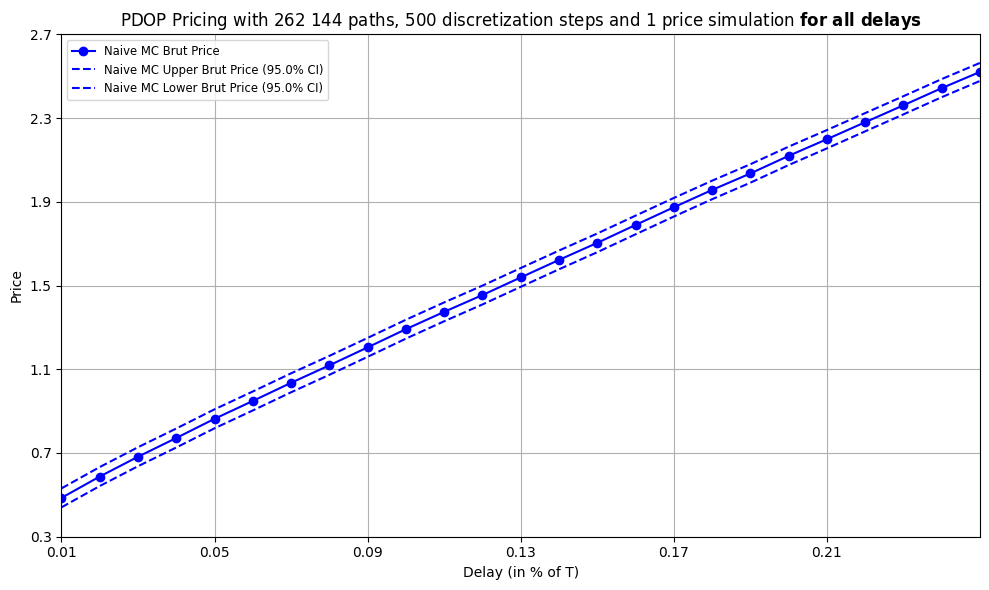

In [35]:
T_plot_prev = 1
(label_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot, ts_plot, n_paths_plot, delays_plot)  = (
    "PDOP", 100, 100, T_plot_prev, 90, 0.2, 0.025, 0, np.linspace(0, T_plot_prev, 500), 2**18, np.linspace(0.01, 0.25, 25))

plot_results(label_plot, ts_plot, n_paths_plot, delays_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot,methods = [Naive_MC_Pricing_function],
             brut_prices = True,plot_adaptative = False,CI = True, unique_price_simulation = True, proba=0.95)

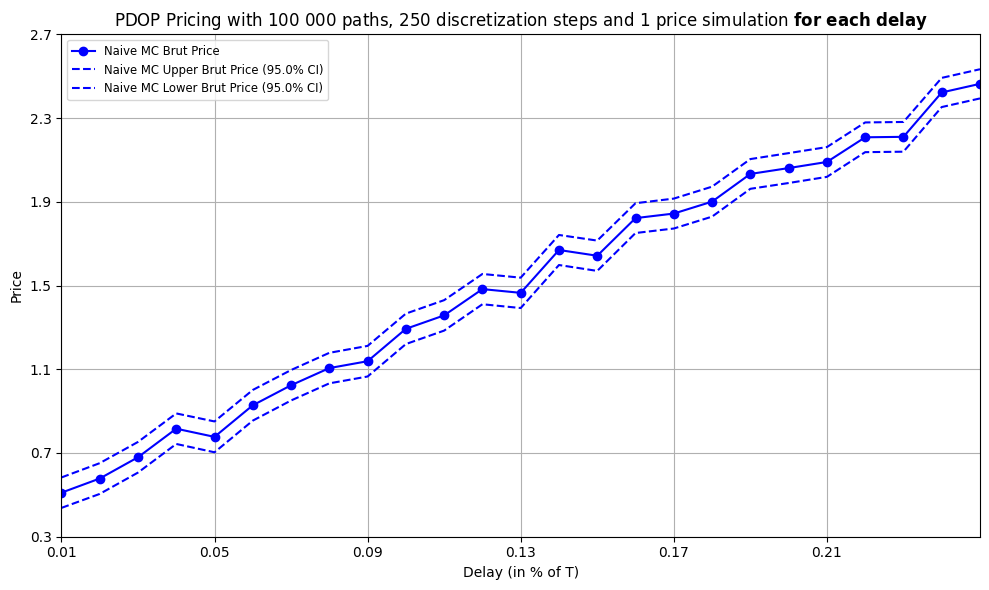

In [36]:
T_plot_prev = 1
(label_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot, ts_plot, n_paths_plot, delays_plot)  = (
    "PDOP", 100, 100, T_plot_prev, 90, 0.2, 0.025, 0, np.linspace(0, T_plot_prev, 250), 100000, np.linspace(0.01, 0.25, 25))

plot_results(label_plot, ts_plot, n_paths_plot, delays_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot,methods = [Naive_MC_Pricing_function],
             brut_prices = True,plot_adaptative = False,CI = True, unique_price_simulation = False, proba=0.95)

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Pricing - Brownian Bridge<h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

**1. Theoretical approach**

We define the centered Brownian bridge as
$$
Y_t^{W,T} = W_t - \frac{t}{T} W_T
$$
such that
$$
\mathbb{E}[Y_t^{W,T}] = 0 \quad \text{and} \quad \text{Cov}(Y_t^{W,T}, Y_s^{W,T}) = \min(s,t) - \frac{st}{T} \quad \text{for } s,t \in [0,T].
$$

 We also have the following equation for all $\lambda \in \mathbb{R}_*$:
$$
\mathbb{P}\left( \inf_{t\in[0,T]} \left( x + (y-x)\frac{t}{T} + \lambda Y_t^{W,T} \right) \geqslant z \right) =
\begin{cases}
1 - \exp\left(-\dfrac{2(z-x)(z-y)}{\lambda^2T}\right) & \text{if } z \leqslant \min(x,y), \\
0 & \text{otherwise}.
\end{cases}
$$

In particular, for all $t_1, t_2 \in [0,T]$ such that $t_2 > t_1$, we have:
$$
\mathbb{P}\left( \inf_{t\in[t_1,t_2]} \left( x + (y-x)\frac{t-t_1}{t_2-t_1} + \lambda Y_t^{W,t_2-t_1} \right) \geqslant z \right) =
\begin{cases}
1 - \exp\left(-\dfrac{2(z-x)(z-y)}{\lambda^2(t_2-t_1)}\right) & \text{if } z \leqslant \min(x,y), \\
0 & \text{otherwise}.
\end{cases}
$$

Let $(\Omega,\mathcal F,(\mathcal F_t)_{t\ge0},\mathbb{Q})$ support a standard Brownian motion $W$.  
Under the risk-neutral measure~$\mathbb{Q}$ the log-price $X_t=\log S_t$ solves
$$
X_t=\Bigl(r-\delta-\tfrac{\sigma^2}{2}\Bigr)dt+\sigma\,dW_t,\qquad X_0= \log(S_0),
$$

with short rate $r$, dividend yield $\delta$, and volatility $\sigma>0$.

The dynamic of $X$ allows for the use of the above Brownian bridge properties. 


Combining the following properties of the logarithm function:

- The logarithm function is increasing on $]0,+\infty[$, so comparing $S_t$ to $L$ is equivalent to comparing $X_t = \log(S_t)$ to $\log(L)$.
- The logarithm function is injective from $]0,+\infty[$ to $]0,+\infty[$. Combined with the growth, the $\sup$ or $\max$ (and respectively the $\inf$ or $\min$) of $S_t$ and of $X_t$ occur at the same times.
- The logarithm function is continuous on $]0,+\infty[$, which ensures that the sigma-fields are equivalent under the change of variables.


We can then derive: 

$$
\begin{aligned}
&\mathbb{P}\left( \inf_{t \in [t_k, t_{k+d}]} \bar{S}_t^n \geqslant L \,\Big|\, \bar{S}_{t_k}^n, \bar{S}_{t_{k+d}}^n \right) \\
&=\mathbb{P}\left( \inf_{t \in [t_k, t_{k+d}]} \log(\bar{S}_t^n) \geqslant \log(L) \,\Big|\, \log(\bar{S}_{t_k}^n), \log(\bar{S}_{t_{k+d}}^n) \right) \\
&=\mathbb{P}\left( \inf_{t \in [t_k, t_{k+d}]} \bar{X}_t^n \geqslant \log(L) \,\Big|\, \bar{X}_{t_k}^n, \bar{X}_{t_{k+d}}^n \right) \\
&= \mathbb{P} \left( \inf_{t \in [t_k, t_{k+d}]} \left( 
\bar{X}_{t_k}^n 
+ \frac{t - t_k}{t_{k+d} - t_k} \left( \bar{X}_{t_{k+d}}^n - \bar{X}_{t_k}^n \right) 
+ \sigma\left(t_k, \bar{X}_{t_k}^n\right) Y_{t-t_k}^{W, t_{k+d}-t_k}
\right) \geqslant \log(L) \right) \\
&= 
\begin{cases}
1 - \exp\left( -\dfrac{2(\log(L)-\bar{X}_{t_k}^n)(\log(L)-\bar{X}_{t_{k+d}}^n)}{\sigma^2(t_k, \bar{X}_{t_k}^n)(t_{k+d} - t_k)} \right) & \text{if } \log(L) \leqslant \min\left( \bar{X}_{t_k}^n , \bar{X}_{t_{k+d}}^n \right) <=>L \leqslant \min\left( \bar{S}_{t_k}^n , \bar{S}_{t_{k+d}}^n \right), \\
0 & \text{otherwise}.
\end{cases} \\
&= 
\begin{cases}
1 - \exp\left( -\dfrac{2\log(\frac{L}{{S}_{t_k}^n})\log(\frac{L}{{S}_{t_{k+d}}^n})}{\sigma^2(t_k, \bar{X}_{t_k}^n)(t_{k+d} - t_k)} \right) & \text{if } L \leqslant \min\left( \bar{S}_{t_k}^n , \bar{S}_{t_{k+d}}^n \right), \\
0 & \text{otherwise}.
\end{cases}
\end{aligned}
$$

We emphasize that the volatility used here is that of the log-price. In our modeling framework, while the volatility of $(S_t)_{t \in [0,T]}$ is $(\sigma S_t)_{t \in [0,T]}$, the volatility of the log-price $(X_t)_{t \in [0,T]}$ is constant and equal to $\sigma$.

We also note that in the case of the Brownian bridge, the distribution of the supremum is known (and can be derived from the equations above). This allows us to deduce the following identity:

$$
\mathbb{P}\left( \sup_{t \in [t_k, t_{k+d}]} \bar{S}_t^n \leqslant L \,\Big|\, \bar{S}_{t_k}^n, \bar{S}_{t_{k+d}}^n \right) 
=
\begin{cases}
1- \exp\left( -\dfrac{2\log(\frac{L}{{S}_{t_k}^n})\log(\frac{L}{{S}_{t_{k+d}}^n})}{\sigma^2(t_k, \bar{X}_{t_k}^n)(t_{k+d} - t_k)} \right)  \text{ if } L \geqslant \max \left( \bar{S}_{t_k}^n, \bar{S}_{t_{k+d}}^n \right), \\[10pt]
0  \text{ otherwise}.
\end{cases}
$$

**2. Empirical approach**

We first simulate $N$ trajectories with by discretizing the interval $[0,T]$ through $M$ steps. We then obtain a ($N,M$) price matrix. We also simulate \((N-1)\times M\) random variables
$$
\bigl(U^i_{j}\bigr)_{i\in\{1,\dots,N-1\},\,j\in\{1,\dots,M\}}
$$
drawn i.i.d. from a standard continuous uniform distribution, i.e. 
$$
U^i_{j}\sim\mathcal{U}([0,1]).
$$

Once we have our simulated trajectories, we introduce our condition steps $D = \bigl\lceil \tfrac{d}{\Delta t}\bigr\rceil$ the number of discretization step the excursion should be as well as our delay counter $\Theta$ defined as follows: 


$$
\Theta^i_{0} = 0,
\qquad
\Theta^i_{j+1}
= 
\begin{cases}
\Theta^i_{j} + 1, &\text{if } S_{t_j}^i \text{and } S_{t_{j+1}}^i \text{ satisfies the barrier condition (Up or Down)} \\ 
& \text{and } U_j^i \le  1- \exp\left( -\dfrac{2\log(\frac{L}{{S}_{t_j}^i})\log(\frac{L}{{S}_{t_{j+1}}^i})}{(t_{j+1} - t_j)\sigma^2}\right) \\
0, &\text{otherwise}.
\end{cases}
$$

*Remark:*In practice, we break the counting loop for $\Theta$ as soon as it exceeds $D$.

We finally compute our prices using a naive Monte Carlo approach :

$$
\widehat{V}
= e^{-rT}\,\frac{1}{M}
\sum_{i=1}^{M}
f\bigl(S^{i}_{t_N}\bigr)\,
\mathbf{1}_{\bigl\{\exists\,j\in\{1,\dots,M\}:\,\Theta^{i}_{j}\ge D\bigr\}} \text{ for In Options}.
$$

$$
\widehat{V}
= e^{-rT}\,\frac{1}{M}
\sum_{i=1}^{M}
f\bigl(S^{i}_{t_N}\bigr)\,
\mathbf{1}_{\bigl\{\forall\,j\in\{1,\dots,M\}:\,\Theta^{i}_{j}< D\bigr\}} \text{ for Out Options}.
$$

### Function:

In [37]:
# ================================= UP CALL & PUT =================================

# =================================================================================
@njit(parallel=True, cache=True)
def MC_PUIP_BB(S0, S, T, K, L, r, q, vol, delay, ts, n_paths,U,give_payoff = False): 

    """
    Monte Carlo simulation for an Up-and-In Put (PUIP) option using Brownian Bridge correction.

    Notes
    -----
    - Accelerated with @njit(parallel=True, cache=True) for major speed-up.
    - Parallelization over the number of simulated paths (prange).
    - Two loops: one for monitoring the barrier condition, one for calculating the payoff.
    - Barrier condition: the asset price must stay above L for 'delay' consecutive time steps.
    
    Parameters
    ----------
    S0: float
        Initial spot price of the underlying.
    S: ndarray
       Simulated asset price paths of shape (n_times, n_paths).
    T: float
       Time to maturity (in years).
    K: float
        Strike price of the option.
    L: float
        Barrier level that needs to be crossed.
    r: float
        Risk-free interest rate (annualized, continuously compounded).
    q: float
       Dividend yield (annualized, continuously compounded).
    vol: float
         Volatility of the underlying asset.
    delay: int
           Minimum consecutive steps above the barrier to trigger activation.
    ts: array_like
        Time steps of the simulation (ascending order).
    n_paths: int
             Number of Monte Carlo paths.
    U: ndarray
       Simulated uniforms on [0,1] to assess the probability of the condition between a interval
    give_payoff: bool
                 If True, returns individual payoffs per path. If False, returns discounted average price.

    Returns
    -------
    result: ndarray or float
        - If give_payoff=True: returns an array of payoffs for each path.
        - If give_payoff=False: returns the discounted average payoff (option price).
    """
    
    payoff = np.zeros(n_paths, dtype=np.float64) # Initialize the payoof to 0 as we are within an In Parisian Option ption 
    n_times = len(ts) # Number of time steps
    dt = ts[1] - ts[0]
    time_vol_correction = -2/(vol**2 * dt)  # Precomputed factor for Brownian Bridge adjustment

    # Barrier crossing detection
    for i in prange(n_paths): # Parallelized across paths
        count = 0 
        for j in range(n_times - 1): 
            if S[j, i] >= L and S[j+1,i] >=L: # If the two extremities of the interval satisfies the condition for a non zero probability
                if 1 - np.exp(time_vol_correction *(np.log(S[j, i]/L))*(np.log(S[j+1, i]/L))) > U[j,i]: # We compare to a uniform to assess if it stayed above the bareer
                    count += 1
                    if count >= delay: # If maintained long enough
                        payoff[i] = max(K - S[-1, i], 0.) # We add the payoff
                        break
                else: 
                    count = 0 # If it breachs during the interval, the counter comes back to 0
            else: 
                count = 0  # Reset counter if condition breaks

    if give_payoff: 
        return payoff # Return array of payoffs
    else : 
        return np.array([np.exp(-r * T) * payoff.mean()]) # Return discounted mean payoff
# =================================================================================

# =================================================================================
@njit(parallel=True, cache=True)
def MC_PUIC_BB(S0, S, T, K, L, r, q, vol, delay, ts, n_paths,U,give_payoff = False): 

    """
    Same structure as MC_PUIP_BB but for Up-and-In Call (PUIC) options.
    - Barrier condition is when spot >= barrier level.
    - Payoff of a call
    """
    
    payoff = np.zeros(n_paths, dtype=np.float64)
    n_times = len(ts) 
    dt = ts[1] - ts[0]
    time_vol_correction = -2/(vol**2 * dt) 

    for i in prange(n_paths): 
        count = 0 
        for j in range(n_times - 1): 
            if S[j, i] >= L and S[j+1,i] >=L:
                if 1 - np.exp(time_vol_correction *(np.log(S[j, i]/L))*(np.log(S[j+1, i]/L))) > U[j,i]: 
                    count += 1
                    if count >= delay:
                        payoff[i] = max(S[-1, i] - K, 0.0)
                        break
                else: 
                    count = 0
            else: 
                count = 0 

    if give_payoff: 
        return payoff 
    else : 
        return np.array([np.exp(-r * T) * payoff.mean()])
# =================================================================================




# ================================ DOWN CALL & PUT ================================

# =================================================================================
@njit(parallel=True, cache=True)
def MC_PDIC_BB(S0, S, T, K, L, r, q, vol, delay, ts, n_paths, U, give_payoff = False): 
    
    """
    Same structure as MC_PUIP_BB but for Down-and-In Call (PDIC) options.
    - Barrier condition is when spot <= barrier level.
    - Payoff of a call
    """
    
    payoff = np.zeros(n_paths, dtype=np.float64)
    n_times = len(ts)
    dt = ts[1] - ts[0]
    time_vol_correction = -2/(vol**2 * dt)

    for i in prange(n_paths): 
        count = 0 
        for j in range(n_times-1):
            if S[j, i] <= L and S[j+1,i] <=L:
                if 1 - np.exp(time_vol_correction *(np.log(S[j, i]/L))*(np.log(S[j+1, i]/L))) > U[j,i]: 
                    count += 1
                    if count >= delay: 
                        payoff[i] = max(S[-1, i] - K, 0.0)
                        break
                else: 
                    count = 0
            else: 
                count = 0

    if give_payoff: 
        return payoff 
    else : 
        return np.array([np.exp(-r * T) * payoff.mean()])
# =================================================================================

# =================================================================================
@njit(parallel=True, cache=True)
def MC_PDIP_BB(S0, S, T, K, L, r, q, vol, delay, ts, n_paths, U, give_payoff = False): 
    
    """
    Same structure as MC_PUIP_BB but for Down-and-In Put (PDIP) options.
    - Barrier condition is when spot <= barrier level.
    - Payoff of a put
    """
    
    payoff = np.zeros(n_paths, dtype=np.float64)
    n_times = len(ts)
    dt = ts[1] - ts[0]
    time_vol_correction = -2/(vol**2 * dt)

    for i in prange(n_paths):  
        count = 0 
        for j in range(n_times-1):
            if S[j, i] <= L and S[j+1,i] <=L:
                if 1 - np.exp(time_vol_correction *(np.log(S[j, i]/L))*(np.log(S[j+1, i]/L))) > U[j,i]: 
                    count += 1
                    if count >= delay: 
                        payoff[i] = max(K-S[-1, i], 0.0)
                        break
                else: 
                    count = 0
            else: 
                count = 0

    if give_payoff: 
        return payoff 
    else : 
        return np.array([np.exp(-r * T) * payoff.mean()])
# =================================================================================

In [38]:
# ================================= PARITY IN-OUT =================================

# =================================================================================
def MC_PDOC_BB (S0,S, T, K, L, r, q, vol, delay, ts, n_paths,U,give_payoff=False):

    """
    Prices a Down-and-Out Call (PDOC) using In-Out Parity with Brownian Bridge correction.

    Parameters
    ----------
    S0: float
        Initial spot price of the underlying.
    S: ndarray
        Simulated asset price paths (n_times, n_paths).
    T: float
        Time to maturity (in years).
    K: float
        Strike price of the option.
    L: float
        Down barrier level.
    r: float
        Risk-free interest rate (annualized, continuously compounded).
    q: float
        Dividend yield (annualized, continuously compounded).
    vol: float
        Volatility of the underlying asset.
    delay: int
        Minimum consecutive steps to validate barrier crossing.
    ts: array_like
        Time grid of the simulation.
    n_paths: int
        Number of Monte Carlo simulation paths.
    give_payoff: bool
        If True, returns individual path payoffs. Otherwise, returns discounted average price.
    U: ndarray
       Simulated uniforms on [0,1] to assess the probability of the condition between a interval
    Returns
    -------
    result: float or ndarray
        Discounted price or pathwise payoffs depending on give_payoff.

    Notes
    -----
    - Relies on the In-Out Parity: Call Down-Out = Vanilla Call - Down-In Call.
    """
    
    discount = np.exp(r*T) if give_payoff else 1 # Discount factor if necessary
    return  discount*BS_call (S0, T, K, r, q, vol) - MC_PDIC_BB (S0, S, T, K, L, r, q, vol, delay, ts, n_paths,U,give_payoff)
# =================================================================================

# =================================================================================
def MC_PUOC_BB (S0,S, T, K, L, r, q, vol, delay, ts, n_paths,U,give_payoff=False): 

    """
    Same structure as MC_PDOC_BB but for Up-and-Out Call (PUOC).
    """
    
    discount = np.exp(r*T) if give_payoff else 1
    return  discount*BS_call (S0, T, K, r, q, vol) - MC_PUIC_BB (S0, S, T, K, L, r, q, vol, delay, ts, n_paths,U,give_payoff)
# =================================================================================

# =================================================================================
def MC_PUOP_BB (S0,S, T, K, L, r, q, vol, delay, ts, n_paths,U,give_payoff=False): 

    """
    Same structure as MC_PUOP_BB but for Up-and-Out Put (PUOP).
    """
    
    discount = np.exp(r*T) if give_payoff else 1
    return  discount*BS_put (S0, T, K, r, q, vol) - MC_PUIP_BB (S0, S, T, K, L, r, q, vol, delay, ts, n_paths,U,give_payoff)
# =================================================================================

# =================================================================================
def MC_PDOP_BB (S0,S, T, K, L, r, q, vol, delay, ts, n_paths,U,give_payoff=False): 

    """
    Same structure as MC_PUOP_BB but for Down-and-Out Put (PDOP).
    """
    
    discount = np.exp(r*T) if give_payoff else 1
    return  discount*BS_put (S0, T, K, r, q, vol) - MC_PDIP_BB (S0, S, T, K, L, r, q, vol, delay, ts, n_paths,U,give_payoff)
# =================================================================================



# ================================== BS CALL-PUT ==================================

# =================================================================================
def BS_call (S0, T, K, r, q, vol): 

    """
    Computes the Black-Scholes price of a European Call option.

    Parameters
    ----------
    Standard Black-Scholes parameters.

    Returns
    -------
    Call price.
    """
    
    d1 = (np.log(S0/K) + (r-q+0.5*(vol**2))*T)/(vol*np.sqrt(T))
    d2 = d1 - vol*np.sqrt(T)
    call_price= S0*(np.exp(-q*T))*norm.cdf(d1) - K*(np.exp(-r*T))*norm.cdf(d2)
    return call_price
# =================================================================================

# =================================================================================
def BS_put (S0, T, K, r, q, vol) : 

    """
    Computes the Black-Scholes price of a European Put option via Call-Put Parity.
    """
    
    return BS_call (S0, T, K, r, q, vol)  - S0 + K*np.exp(-r*T)
# =================================================================================



# ========================== GLOBAL REDIRECTION FUNCTION ==========================

# =================================================================================
def Brownian_Bridge_Pricing_function (label, S, S0, T, K, L, r, q, vol, delay, ts, n_paths, get_payoff = False, U=None):

    """
    Dispatcher function to select Brownian Bridge-enhanced MC pricing based on the label.

    Parameters
    ----------
    label: str
        Key to select the appropriate pricing method ("PUIC", "PDIC", etc.).
    S: ndarray
        Simulated asset price paths.
    S0: float
        Initial spot price.
    T: float
        Time to maturity.
    K: float
        Strike price.
    L: float
        Barrier level.
    r: float
        Risk-free interest rate.
    q: float
        Dividend yield.
    vol: float
         Volatility.
    delay: int
           Number of consecutive hits needed.
    ts: array_like
        Time steps.
    n_paths: int
             Number of simulated paths.
    get_payoff: bool
                If True, returns all payoffs; otherwise returns discounted average.
    U: ndarray
       Simulated uniforms on [0,1] to assess the probability of the condition between a interval. 
       By default full of zeros, so will have the same behavior as the naive Monte Carlo approach. 

    Returns
    -------
    result: float or ndarray
        Option price or array of payoffs.
    """
    
    pricing_functions = {
    "PDIC": MC_PDIC_BB,
    "PDOC": MC_PDOC_BB,
    "PUIC": MC_PUIC_BB,
    "PUOC": MC_PUOC_BB,
    "PDIP": MC_PDIP_BB,
    "PDOP": MC_PDOP_BB,
    "PUIP": MC_PUIP_BB,
    "PUOP": MC_PUOP_BB,
    }

    if U is None:
        U = np.zeros((len(ts)-1, n_paths), dtype=np.float32)
        
    try:
        func = pricing_functions[label]
    except KeyError:
        raise ValueError(f"Label '{label}' is not a callable function. Available labels: {list(pricing_functions.keys())}")
    return func(S0, S, T, K, L, r, q, vol, delay, ts, n_paths, U, get_payoff)
# =================================================================================

### Display:

In [39]:
T_pricing_prev = 1 
(labels_pricing, ts_pricing, n_paths_pricing, delay_pricing, S0_pricing, K_pricing, T_pricing, L_pricing, vol_pricing, r_pricing, q_pricing) = (
    [("PDIC","PDOC"), ("PUIC","PUOC"), ("PDIP","PDOP"), ("PUIP", "PUOP")], np.linspace(0,T_pricing_prev,500), 1000000,0.13, 100, 100, T_pricing_prev, 90, 0.2, 0.025, 0)
method_pricing = Brownian_Bridge_Pricing_function
print_pricing_data(labels_pricing, ts_pricing, n_paths_pricing, delay_pricing, S0_pricing, K_pricing, T_pricing, L_pricing, vol_pricing, r_pricing, q_pricing,method_pricing)


Pricing with Brownian Bridge: 

Number of paths, discretization    : (1000000, 500)
Time - Generate W     : 17.4691 sec
Time - Simulate S    : 9.6246 sec
Time - Simulate U    : 37.1964 sec

PDIC: 0.194589 (var = 2.906e+00, time = 4.9217 sec)
PDOC: 8.968322 (var = 2.906e+00, time = 1.5162 sec)
Call: 9.162911 (time = 0.0080 sec)
Difference PDIC+PDOC - Call: -0.000000000

PUIC: 9.168444 (var = 1.947e+02, time = 2.0918 sec)
PUOC: -0.005533 (var = 1.947e+02, time = 2.2369 sec)
Call: 9.162911 (time = 0.0020 sec)
Difference PUIC+PUOC - Call: 0.000000000

PDIP: 5.188864 (var = 9.259e+01, time = 1.5494 sec)
PDOP: 1.505039 (var = 9.259e+01, time = 1.7585 sec)
Put: 6.693902 (time = 0.0000 sec)
Difference PDIP+PDOP - Put: 0.000000000

PUIP: 5.578292 (var = 7.555e+01, time = 1.8409 sec)
PUOP: 1.115610 (var = 7.555e+01, time = 1.7722 sec)
Put: 6.693902 (time = 0.0000 sec)
Difference PUIP+PUOP - Put: 0.000000000




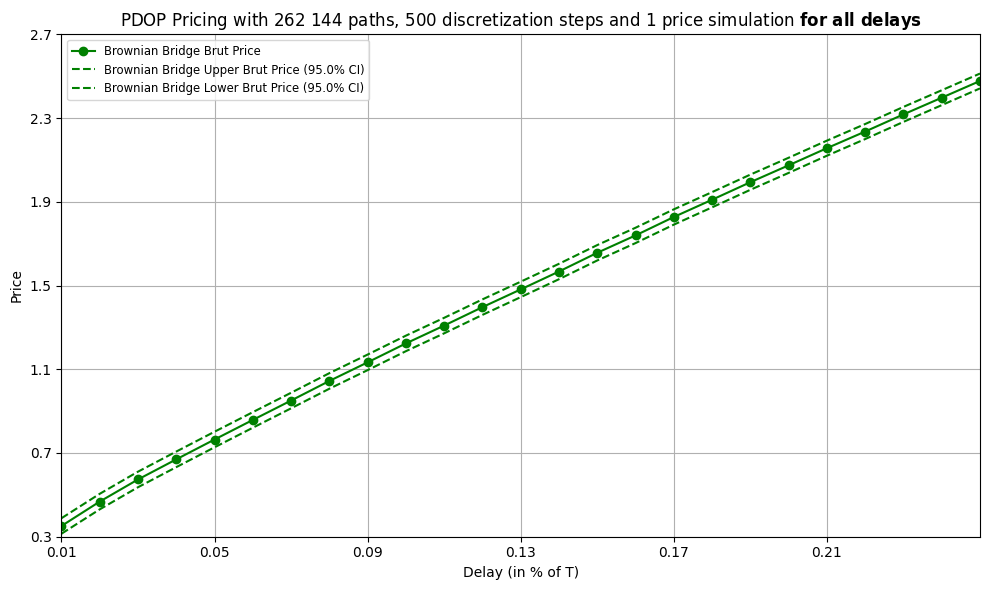

In [40]:
T_plot_prev = 1
(label_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot, ts_plot, n_paths_plot, delays_plot)  = (
    "PDOP", 100, 100, T_plot_prev, 90, 0.2, 0.025, 0, np.linspace(0, T_plot_prev, 500), 2**18, np.linspace(0.01, 0.25, 25))

plot_results(label_plot, ts_plot, n_paths_plot, delays_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot,methods = [Brownian_Bridge_Pricing_function],
             brut_prices = True,plot_adaptative = False,CI = True, unique_price_simulation = True, proba=0.95)

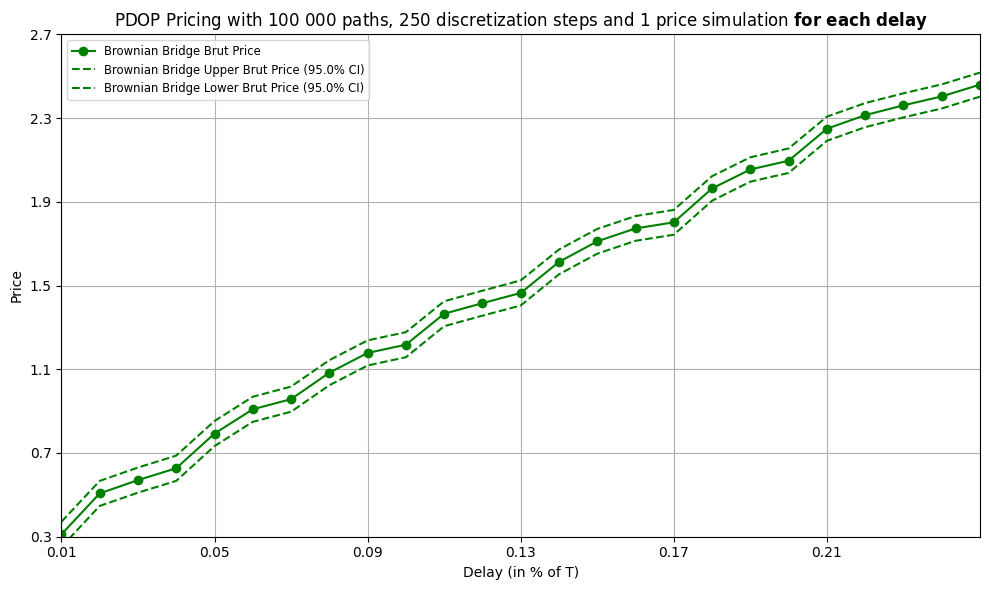

In [41]:
T_plot_prev = 1
(label_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot, ts_plot, n_paths_plot, delays_plot)  = (
    "PDOP", 100, 100, T_plot_prev, 90, 0.2, 0.025, 0, np.linspace(0, T_plot_prev, 250), 100000, np.linspace(0.01, 0.25, 25))

plot_results(label_plot, ts_plot, n_paths_plot, delays_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot,methods = [Brownian_Bridge_Pricing_function],
             brut_prices = True,plot_adaptative = False,CI = True, unique_price_simulation = False, proba=0.95)

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Laplace inversion method<h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>



### Laplace Transform and Convolution

For $f:[0,\infty)\to\mathbb R$,
$$
\widehat f(\lambda) = \int_0^\infty e^{-\lambda t}f(t)\,dt,
$$
and if \((f * g)(t) = \int_0^t f(t-u)\,g(u)\,du\), then
$$
\widehat{f*g}(\lambda) = \widehat f(\lambda)\,\widehat g(\lambda).
$$


**Key Variables**

Set
$$
\theta = \sqrt{2\lambda}, 
\quad
k = \tfrac1\sigma\ln(K/x), 
\quad
d = \frac{b-k}{\sqrt D},
$$


### Laplace Transform of PDIC

Assume $$\theta=\sqrt{2\lambda},\quad b=\frac{1}{\sigma}\ln\frac{L}{x},\quad k=\frac{1}{\sigma}\ln\frac{K}{x},\quad d=\frac{b-k}{\sqrt{D}}.$$   
Then  
$$
\widehat{\mathrm{PDIC}}^\star(x,\lambda;K,L)
=\frac{e^{\theta b}}{D\,\theta\,\psi(\theta\sqrt{D})}
\int_{k}^{\infty}e^{m y}\,(x e^{\sigma y}-K)\,K_{\lambda,D}(b-y)\,dy.
$$

**Case $K>L$:**  
$$
\widehat{\mathrm{PDIC}}^\star(x,\lambda)
=\frac{\psi(-\theta\sqrt{D})\,e^{2\theta b}}{\theta\,\psi(\theta\sqrt{D})}
\,K\,e^{(m-\theta)k}
\Bigl(\tfrac{1}{m-\theta}-\tfrac{1}{m+\sigma-\theta}\Bigr).
$$

**Case $K\le L$:**  
$$
\begin{aligned}
\widehat{\mathrm{PDIC}}^\star(x,\lambda)
&=\frac{e^{(m+\theta)b}}{\psi(\theta\sqrt{D})}
\Bigl[
\frac{2K}{m^2-\theta^2}\,\psi(m\sqrt{D})
-m\sqrt{2\pi D}\,e^{\tfrac{D m^2}{2}}\,N(m\sqrt{D}+d)\\
&\quad\quad
-\frac{2L}{(m+\sigma)^2-\theta^2}
\Bigl(\psi((m+\sigma)\sqrt{D})
-(m+\sigma)\sqrt{2\pi D}\,e^{\tfrac{D(m+\sigma)^2}{2}}\,N((m+\sigma)\sqrt{D}+d)\Bigr)
\Bigr]\\
&\quad
+\frac{K\,e^{(m+\theta)k}}{\theta\,\psi(\theta\sqrt{D})}
\Bigl(\tfrac{1}{m+\theta}-\tfrac{1}{m+\sigma+\theta}\Bigr)
\Bigl[\psi(\theta\sqrt{D})
-\theta\sqrt{2\pi D}\,e^{\lambda D}\,N(\theta\sqrt{D}-d)\Bigr]\\
&\quad
+\frac{e^{\lambda D}\sqrt{2\pi D}}{\psi(\theta\sqrt{D})}
\,K\,e^{2\theta b}e^{(m-\theta)k}\,
N(-d-\theta\sqrt{D})
\Bigl(\tfrac{1}{m+\sigma-\theta}-\tfrac{1}{m-\theta}\Bigr).
\end{aligned}
$$


### Laplace Transform of PUIC

With the same definitions of $\theta,b,k,d,K_{\lambda,D},\psi$,  
$$
\widehat{\mathrm{PUIC}}^\star(x,\lambda;K,L)
=\frac{e^{-\theta b}}{D\,\theta\,\psi(\theta\sqrt{D})}
\int_{k}^{\infty}e^{m y}\,(x e^{\sigma y}-K)\,K_{\lambda,D}(y-b)\,dy.
$$

**Case $K>L$:**  
$$
\begin{aligned}
\widehat{\mathrm{PUIC}}^\star(x,\lambda)
&=\frac{2\,e^{(m-\theta)b}}{\sqrt{2\pi D}\,\psi(\theta\sqrt{D})}
\Bigl[
\frac{K}{m^2-\theta^2}\,e^{\tfrac{D m^2}{2}}\,m\,N(m\sqrt{D}+d)\\
&\quad\quad
-\frac{L}{(m+\sigma)^2-\theta^2}\,e^{\tfrac{D(m+\sigma)^2}{2}}\,(m+\sigma)\,
N((m+\sigma)\sqrt{D}+d)
\Bigr]\\
&\quad
+\frac{e^{-2\theta b}}{\psi(\theta\sqrt{D})}
\,K\,e^{(m+\theta)k}\,e^{\lambda D}\sqrt{2\pi D}\,
N(d-\theta\sqrt{D})
\Bigl(\tfrac{1}{m+\sigma+\theta}-\tfrac{1}{m+\theta}\Bigr)\\
&\quad
+\frac{e^{(m-\theta)k}}{\theta\,\psi(\theta\sqrt{D})}
\,K\,
\Bigl(\tfrac{1}{m-\theta}-\tfrac{1}{m+\sigma-\theta}\Bigr)
\Bigl[\psi(\theta\sqrt{D})
-\theta\sqrt{2\pi D}\,e^{\lambda D}\,N(d+\theta\sqrt{D})\Bigr].
\end{aligned}
$$

**Case $K\le L$:**  
$$
\begin{aligned}
\widehat{\mathrm{PUIC}}^\star(x,\lambda)
&=\frac{2\,e^{(m-\theta)b}}{\psi(\theta\sqrt{D})}
\Bigl[\frac{K}{m^2-\theta^2}\,\psi(m\sqrt{D})
-\frac{L}{(m+\sigma)^2-\theta^2}\,\psi((m+\sigma)\sqrt{D})\Bigr]\\
&\quad
+\frac{e^{-2\theta b}\,\psi(-\theta\sqrt{D})}{\theta\,\psi(\theta\sqrt{D})}
\,K\,e^{(m+\theta)k}
\Bigl(\tfrac{1}{m+\theta}-\tfrac{1}{m+\theta+\sigma}\Bigr).
\end{aligned}
$$

### Numerical Inversion

**Trapezoidal Rule (Euler–Accelerated):**  
$$
f_{\pi/t}(t)
= \frac{e^{\alpha t}}{2t}\,\widehat f(\alpha)
  + \frac{e^{\alpha t}}{t}
    \sum_{k=1}^\infty (-1)^k
    \Re\!\Bigl[\widehat f\bigl(\alpha + i\tfrac{k\pi}{t}\bigr)\Bigr],
$$
error $\le \|f\|_\infty\,\tfrac{e^{-2\alpha t}}{1 - e^{-2\alpha t}}$.

### Euler Acceleration: 
$$
E(q,p,t)
= \sum_{j=0}^q \binom qj 2^{-q}\;s_{p+j}(t),
$$
with global error $O(e^{-2\alpha t}) + O(p^{-(q+3)})$.

### Function:

In [42]:
# =================================================================================
def N(z):
    
    """
    Standard normal CDF extended to complex via NumPy.
    """
    
    return 0.5 * (1.0 + erf(z / np.sqrt(2.0)))
# =================================================================================

# =================================================================================
def psi(z):
    
    """
    Analytic function on the complex plane given by Definition 10.
    Appears in Laplace transform kernels involving the Parisian delay D.
    """
    
    return 1 + z * np.sqrt(2*np.pi) * np.exp(z**2/2) * N(z)
# =================================================================================

# =================================================================================
@njit
def laplace_BSC_star(lambda_, x, K, r, q, sigma):
    
    """
    Laplace transform of the vanilla Black-Scholes call.

    Notes
    -----
    - Compiled with @njit for fast repeated evaluations.
    - Used as a baseline to compute Laplace-space Parisian prices.

    Parameters
    ----------
    lambda_: float
        Laplace variable.
    x: float
        Spot price.
    K: float
        Strike price.
    r: float
        Risk-free rate.
    q: float
       Continuous dividend yield.
    sigma: float
           Volatility.

    Returns
    -------
    result: float
            Laplace-transformed value of the vanilla call.
    """
    
    m = (r - q - 0.5*sigma**2) / sigma # Drift term normalized
    theta_sq = 2.0 * lambda_
    theta = np.sqrt(theta_sq)
    inv_sigma = 1.0 / sigma
    k = inv_sigma * np.log(K / x) # Log-moneyness
    m_minus_theta = m - theta
    m_plus_theta = m + theta 
    
    if K >= x:
        term = (K/theta) * np.exp((m_minus_theta)*k)
        result = term * (1.0/(m_minus_theta) - 1.0/(m_minus_theta + sigma))
        return result
    else:
        num1 = 2*K/(m**2 - theta_sq)
        num2 = 2*x/((m+sigma)**2 - theta_sq)
        termC = (K*np.exp((m_plus_theta)*k)/theta) * (1.0/(m_plus_theta) - 1.0/(m_plus_theta+sigma))
        return num1 - num2 + termC
# =================================================================================

# =================================================================================
def K_lambda_D(lambda_, a, theta, D):

    """
    Laplace-star transform of the vanilla Black-Scholes call (Proposition 3).

    Parameters
    ----------
    lambda_: float  
              Laplace transform variable.
    x: float  
       Spot price.
    K: float  
       Strike price.
    r: float  
       Risk-free rate.
    q: float  
       Continuous dividend yield.
    sigma: float  
           Volatility.

    Returns
    -------
    result: float  
            Laplace-domain value of the European call option.
    """
    
    if a <= 0:
        return np.exp(theta*a) * (D * psi(-theta*np.sqrt(D)))
    else:
        
        D_sqrt = np.sqrt(D)
        a_D_sqrt = a/D_sqrt
        theta_a = theta*a
        theta_D_sqrt = theta*D_sqrt

        result = (
            np.exp(-theta_a) * D * psi(theta*D_sqrt)
            - D * theta * np.sqrt(2*np.pi*D) * np.exp(lambda_*D) * (
                N(theta_D_sqrt - a_D_sqrt) * np.exp(-theta_a)
                + N(-theta_D_sqrt - a_D_sqrt) * np.exp(theta_a)
            )
        )

        return result 
# =================================================================================

# =================================================================================
def K_lambda_D_vec(lambda_, a_vec, theta, D):

    """
    Scalar form of the Parisian delay kernel K_{λ,D}(a).

    Parameters
    ----------
    lambda_: float  
              Laplace variable.
    a: float  
       Distance from the barrier.
    theta: float  
            Square root of 2 * lambda.
    D: float  
       Parisian delay.
       
    Returns
    -------
    result: complex  
            Value of the Parisian kernel at point a.
    """
    
    D_sqrt = np.sqrt(D)
    theta_D_sqrt = theta * D_sqrt
    theta_a = theta * a_vec
    exp_lambda_D = np.exp(lambda_ * D)
    psi_val = psi(theta_D_sqrt)
    D_psi_val = D * psi_val
    sqrt_2pi_D = np.sqrt(2 * np.pi * D)

    res = np.empty_like(a_vec, dtype=complex)
    mask_neg = a_vec <= 0
    if np.any(mask_neg):
        res[mask_neg] = np.exp(theta_a[mask_neg]) * (D * psi(-theta_D_sqrt))

    mask_pos = ~mask_neg
    if np.any(mask_pos):
        a_pos = a_vec[mask_pos]
        theta_a_pos = theta_a[mask_pos]
        exp_theta_a = np.exp(-theta_a_pos)
        exp_neg_theta_a = np.exp(theta_a_pos)
        a_D_sqrt_pos = a_pos / D_sqrt
        N1 = N(theta_D_sqrt - a_D_sqrt_pos)
        N2 = N(-theta_D_sqrt - a_D_sqrt_pos)

        correction = D * theta * sqrt_2pi_D * exp_lambda_D * (
            N1 * exp_theta_a + N2 * exp_neg_theta_a
        )

        res[mask_pos] = exp_theta_a * D_psi_val - correction

    return res
# =================================================================================

# =================================================================================
def _reduce_to_zero_PUIC(lambda_, x, K, L, r,q, sigma, D):

    """
    Handles the special case where the barrier has already been crossed (b < 0)
    for the Up-and-In Parisian Call, using analytic reduction.

    Parameters
    ----------
    lambda_: float  
              Laplace transform variable.

    x: float  
       Spot price.
    K: float  
       Strike price.
    L: float  
       Barrier level.
    r: float  
       Risk-free rate.
    q: float  
       Dividend yield.
    sigma: float  
            Volatility.
    D: float  
       Parisian delay.

    Returns
    -------
    value: float  
           Laplace-space price of the Parisian Up-and-In Call in the b < 0 case.
    """
    
    b = (1.0/sigma) * np.log(L/x) # Log-distance to barrier
    theta = np.sqrt(2.0 * lambda_) # Appears throughout the Laplace kernel
    m = (r - q - 0.5*sigma**2)/sigma
    D_sqrt = np.sqrt(D)
    b_divided_D_sqrt = b/D_sqrt
    theta_D_sqrt = theta*D_sqrt
    theta_b = theta*b

    # Integral adjustment term μ (mu), from Lemma 1
    mu_int = (
        np.exp(-theta_b)*N(theta_D_sqrt - b_divided_D_sqrt)
        + np.exp(theta_b)*N(-theta_D_sqrt - b_divided_D_sqrt)
    )

    # Compute the price of the Up-and-Out Call (PUOC) via in-out parity
    puoc0 = laplace_BSC_star(lambda_, 1, K/L, r, q, sigma) \
            - laplace_P_U_in_call(lambda_, 1, K/L, 1, r, q, sigma, D)
  
    puoc = L * np.exp(b * m) * puoc0 * mu_int # Final adjustment back to the actual x, K, L

    return laplace_BSC_star(lambda_, x, K, r, q, sigma) - puoc # In-Out symmetry
# =================================================================================

# =================================================================================
def _reduce_to_zero_PDIC(lambda_, x, K, L,r, q, sigma, D):
    """
    Handles the special case where the barrier has already been crossed (b > 0)
    for the Down-and-In Parisian Call, using analytic reduction.

    Parameters
    ----------
    lambda_: float  
              Laplace transform variable.

    x: float  
       Spot price.
    K: float  
       Strike price.
    L: float  
       Barrier level.
    r: float  
       Risk-free rate.
    q: float  
       Dividend yield.
    sigma: float  
            Volatility.
    D: float  
       Parisian delay.

    Returns
    -------
    value: float  
           Laplace-space price of the Parisian Down-and-In Call in the b > 0 case.
    """
    b     = (1.0/sigma) * np.log(L/x)
    theta = np.sqrt(2.0 * lambda_)
    m     = (r - q - 0.5*sigma**2) / sigma
    mu_int = (
        np.exp(-theta*b)*N(theta*np.sqrt(D) - b/np.sqrt(D))
        + np.exp(theta*b)*N(-theta*np.sqrt(D) - b/np.sqrt(D))
    )
    # reciprocal Up-and-Out call at x=1, K→K/L, L=1
    pdoc0 = laplace_BSC_star(lambda_, 1, K/L, r, q, sigma) \
            - laplace_P_D_in_call(lambda_, 1, K/L, 1, r, q, sigma, D)
    pdoc = L * np.exp(b*m) * pdoc0 * mu_int
    return laplace_BSC_star(lambda_, x, K, r, q, sigma) - pdoc
# =================================================================================
    
# =================================================================================
def laplace_P_U_in_call(lambda_, x, K, L, r, q, sigma, D):
    """
        Laplace-star transform of a Parisian Up-and-In Call option (b ≥ 0 case).

        Parameters
        ----------
        lambda_: float  
                Laplace variable.
        x: float  
        Spot price.
        K: float  
        Strike price.
        L: float  
        Barrier level.
        r: float  
        Risk-free rate.
        q: float  
        Dividend yield.
        sigma: float  
                Volatility.
        D: float  
        Parisian delay before activation.

        Returns
        -------
        value: float  
            Laplace-space value of the Parisian Up-and-In Call.
        """

    m = (r - q - 0.5 * sigma**2) / sigma
    theta = np.sqrt(2.0 * lambda_)
    b = (1.0 / sigma) * np.log(L / x)
    k = (1.0 / sigma) * np.log(K / x)
    d = (b - k) / np.sqrt(D)
    b = (1.0/sigma) * np.log(L/x)
    if b >= 0:
        # precompute frequently used
        sqrt2piD = np.sqrt(2.0 * np.pi * D)
        psi_theta = psi(theta * np.sqrt(D))

        # branch by K vs L
        if K > L:
            term1 = (2.0 * np.exp((m - theta) * b) *sqrt2piD /psi_theta) * (
                K / (m*m - theta*theta) * np.exp(0.5 * D * m*m) * m * N(m * np.sqrt(D) + d)
                - L / ((m+sigma)*(m+sigma) - theta*theta) * np.exp(0.5 * D * (m+sigma)**2) * (m+sigma) * N((m+sigma) * np.sqrt(D) + d)
            )
            term2 = (np.exp(-2.0 * b * theta) / psi_theta) * (
                K * np.exp((m + theta) * k) * np.exp(lambda_ * D) * sqrt2piD * N(d - theta * np.sqrt(D))
                * (1.0 / (m + sigma + theta) - 1.0 / (m + theta))
            )
            term3 = (np.exp((m - theta) * k) / (theta * psi_theta)) * (
                K * (1.0 / (m - theta) - 1.0 / (m + sigma - theta))
                * (psi_theta - theta * sqrt2piD * np.exp(lambda_ * D) * N(d + theta * np.sqrt(D)))
            )
            return term1 + term2 + term3
        else:
            term1 = (2.0 * np.exp((m - theta) * b) / psi_theta) * (
                K / (m*m - theta*theta) * psi(m * np.sqrt(D))
                - L / ((m+sigma)*(m+sigma) - theta*theta) * psi((m+sigma) * np.sqrt(D))
            )
            term2 = (np.exp(-2.0 * b * theta) * psi(-theta * np.sqrt(D))
                    / (theta * psi_theta) * K * np.exp((m + theta) * k)
                    * (1.0 / (m + theta) - 1.0 / (m + theta + sigma)))
            return term1 + term2
    else:
        return _reduce_to_zero_PUIC(lambda_, x, K, L, r, q, sigma, D)
# =================================================================================

# =================================================================================
def laplace_P_D_in_call(lambda_, x, K, L, r, q, sigma, D):
    
    """
    Laplace-star transform of a Parisian Down-and-In Call option (b ≤ 0 case).

    Parameters
    ----------
    lambda_: float  
              Laplace variable.
    x: float  
       Spot price.
    K: float  
       Strike price.
    L: float  
       Barrier level.
    r: float  
       Risk-free rate.
    q: float  
       Dividend yield.
    sigma: float  
            Volatility.
    D: float  
       Parisian delay before activation.

    Returns
    -------
    value: float  
           Laplace-space value of the Parisian Down-and-In Call.
    """
    
    m = (r - q - 0.5 * sigma**2) / sigma
    theta = np.sqrt(2.0 * lambda_)
    # for down barrier, b = (1/σ) log(x/L)
    b = (1.0 / sigma) * np.log(L/x)
    k = (1.0 / sigma) * np.log(K / x)
    d = (b - k) / np.sqrt(D)
    sqrtD = np.sqrt(D)
    sqrt2piD = np.sqrt(2.0 * np.pi * D)
    psi_theta = psi(theta * sqrtD)
    
    if b <=0:
        if K > L:
            # formula (9)
            return psi(-theta * sqrtD) * np.exp(2.0 * b * theta) / (theta * psi_theta) * (
                K * np.exp((m - theta) * k) * (1.0/(m - theta) - 1.0/(m + sigma - theta))
            )
        else:
            # formula (10)
            part1 = np.exp((m + theta) * b) / psi_theta * (
                2.0 * K / (m*m - theta*theta) * (psi(m * sqrtD)
                - m * sqrt2piD * np.exp(0.5 * D * m*m) * N(m * sqrtD + d))
                - 2.0 * L / ((m+sigma)*(m+sigma) - theta*theta) * (psi((m+sigma) * sqrtD)
                - (m+sigma) * sqrt2piD * np.exp(0.5 * D * (m+sigma)**2) * N((m+sigma) * sqrtD + d))
            )
            part2 = K * np.exp((m + theta) * k) / (theta * psi_theta) * (1.0/(m + theta) - 1.0/(m + sigma + theta)) * (
                psi_theta - theta * sqrt2piD * np.exp(lambda_ * D) * N(theta * sqrtD - d)
            )
            part3 = np.exp(lambda_ * D) * sqrt2piD / psi_theta * (
                K * np.exp(2.0 * b * theta + (m - theta) * k) * N(-d - theta * sqrtD) * (1.0/(m+sigma - theta) - 1.0/(m - theta))
            )
            return part1 + part2 + part3
    else:
        return _reduce_to_zero_PDIC(lambda_, x, K, L, r, q, sigma, D)
# =================================================================================

# =================================================================================
def prepare_fhat(fhat, t, alpha, p=15, q=15):
    
    """
    Prepares Laplace transform samples f̂(λ) needed for Euler inversion.

    Parameters
    ----------
    fhat: callable  
          Laplace-transformed function to evaluate.
    t: float  
       Target time (typically maturity).
    alpha: float  
           Bromwich shift (must be > singularities of f̂).
    p: int  
       Euler truncation parameter (precision control).
    q: int  
       Euler smoothing parameter (precision control).

    Returns
    -------
    fhat_alpha_real: float  
                     Real part of f̂(α) (first term of the sum).
    fhat_vals: ndarray  
               Real parts of f̂(α + i·π·j / t) for j in 1..p+q
    """
    
    h = np.pi / t # Spacing of the Laplace grid
    max_n = p + q
    j_vals = np.arange(1, max_n + 1, dtype=np.int32)
    lam_vals = alpha + 1j * h * j_vals # Laplace nodes along vertical line

    # Parallel evaluation of real parts of f̂(λ)
    with ThreadPoolExecutor() as executor:
        fhat_vals = np.fromiter(
            executor.map(lambda lam: fhat(lam).real, lam_vals),
            dtype=np.float64,
            count=max_n
        )

    fhat_alpha_real = fhat(alpha).real # First term f̂(α)
    return fhat_alpha_real, fhat_vals
# =================================================================================

# =================================================================================
@njit
def comb(q, k):

    """
    Computes binomial coefficient C(q, k) = q! / (k!(q−k)!) using integer operations.

    Notes
    -----
    - Accelerated with @njit for fast combinatorics in the Euler method.
    - Used to weight each term in the Euler sum.

    Parameters
    ----------
    q: int
       Total number of elements.
    k: int
        Size of the subset.

    Returns
    -------
    result: int
            Binomial coefficient.
    """
    
    if k < 0 or k > q:
        return 0
    if k == 0 or k == q:
        return 1
    num = 1
    denom = 1
    for i in range(1, k+1):
        num *= (q - (k - i)) # Build numerator
        denom *= i # Build denominator
    return num // denom
# =================================================================================

# =================================================================================
@njit
def cumsum(arr):

    """
    Computes cumulative sum of a 1D array in a Numba-compatible way.

    Notes
    -----
    - Compiled with @njit for high performance inside Euler Laplace inversion.
    - Avoids Python for-loop overhead in large summations.

    Parameters
    ----------
    arr: ndarray
         Input array.

    Returns
    -------
    result: ndarray
            Cumulative sum of arr.
    """
    
    result = np.empty_like(arr)
    total = 0.0
    for i in range(arr.shape[0]):
        total += arr[i] # Incremental accumulation
        result[i] = total
    return result
# =================================================================================

# =================================================================================
@njit(parallel=True, cache=True)
def laplace_inversion_euler(fhat_alpha_real, fhat_vals, t, alpha, p=15, q=15):

    """
    Applies Euler acceleration to invert Laplace transform numerically.

    Notes
    -----
    - Compiled with @njit(parallel=True, cache=True) for speed.
    - Loops over q are parallelized with prange.
    - Used to recover real-time price from Laplace-space pricing.

    Parameters
    ----------
    fhat_alpha_real: float
                     Real part of f̂(α), the Laplace transform at the contour shift.

    fhat_vals: ndarray
               Real parts of f̂(α + i·π·j / t) for j in 1..(p+q).

    t: float
       Time horizon (maturity).

    alpha: float
           Bromwich shift (ensures convergence of Laplace inversion).

    p: int
       Euler truncation depth.

    q: int
       Euler smoothing parameter.

    Returns
    -------
    result: float
            Estimated value f(t) from inverse Laplace transform.
    """
     
    h = np.pi / t # Spacing in Laplace domain
    j_vals = np.arange(1, fhat_vals.shape[0]+1)
    signed_fhat_vals = np.empty_like(fhat_vals)

    # Assign alternating signs: (-1)^j * f̂(λ_j)
    for i in prange(j_vals.shape[0]):
        signed_fhat_vals[i] = ((-1)**j_vals[i]) * fhat_vals[i]

    cumsum_signed = cumsum(signed_fhat_vals) # Cumulative sum of alternating series

    # Partial sums needed for Euler acceleration
    partial_sums = np.empty(q+1)
    for k in prange(q+1):
        n = p + k
        partial_sums[k] = cumsum_signed[n - 1]

    # Weighted Euler sum over binomial coefficients
    euler = 0.0
    for k in prange(q+1):
        c = comb(q, k)
        euler += c * (0.5 * fhat_alpha_real + partial_sums[k])

    return np.exp(alpha * t) * euler / (2 ** q * t)
# =================================================================================

# =================================================================================
def compute_alpha_direct(r, q, vol, T, tol=1e-6):

    """
    Computes a valid Bromwich alpha shift for Laplace inversion in direct pricing.

    Notes
    -----
    - Ensures numerical stability of Laplace inversion.
    - Adds buffer above theoretical alpha_min to guarantee convergence.

    Parameters
    ----------
    r: float
        Risk-free rate.
    q: float
        Dividend yield (unused here).
    vol: float
        Volatility.
    T: float
        Maturity.
    tol: float
        Tolerance for numerical decay.

    Returns
    -------
    alpha: float
        Recommended Bromwich shift α for stable inversion.
    """
    
    m = (r -q - 0.5*vol**2) / vol # Risk-neutral drift
    alpha_min = (m + vol)**2 / 2.0 # Minimal admissible alpha
    alpha_tgt = -np.log(tol / (1 + tol)) / (2*T) # From exponential decay
    return max(alpha_min + 1e-3, alpha_tgt) # Add margin to avoid underestimation
# =================================================================================

# =================================================================================
def compute_alpha_recip(r, q, vol, T, tol=1e-4):

    """
    Computes Bromwich shift α for Laplace inversion under inverted process (e.g. put via call).

    Notes
    -----
    - Adjusted drift uses dividend rate q instead of r.
    - Used in price symmetry / inversion methods.

    Parameters
    ----------
    r: float
       Risk-free rate.
    q: float
       Dividend yield (enters drift here).
    vol: float
        Volatility.
    T: float
       Maturity.
    tol: float
         Tolerance for numerical decay.

    Returns
    -------
    alpha: float
        Recommended Bromwich shift α for stable inversion.
    """
    
    m = (q -r- 0.5*vol**2) / vol  # Inverted drift under put symmetry
    alpha_min = (m + vol)**2 / 2.0
    alpha_tgt = -np.log(tol / (1 + tol)) / (2*T)
    return max(alpha_min + 1e-3, alpha_tgt)
# =================================================================================



# ================================== BS CALL-PUT ==================================

# =================================================================================
def black_scholes_call_price(S, K, r, q, sigma, T):
    if T <= 0:
        return max(S-K, 0.0)
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*np.exp(-q*T)*N(d1) - K*np.exp(-r*T)*N(d2)
# =================================================================================

# =================================================================================
def black_scholes_put_price(S, K, r, q, sigma, T):
    c = black_scholes_call_price(S, K, r, q, sigma, T)
    return c + K*np.exp(-r*T) - S*np.exp(-q*T)
# =================================================================================




# =========================== GLOBAL REDIRECTION FUNCTION =========================

# =================================================================================
def Laplace_Pricing_function(label,S, S0, T, K, L,r, q, vol, delay,ts, n_paths=None, get_payoff = False, U=0):

    """
    Computes the Laplace-based price of a single Parisian option using label-based dispatch.

    Notes
    -----
    - Supports inversion and in-out parity pricing logic.
    - Uses Laplace transform + Euler inversion for PUIC/PDIC base cases.
    - Symmetry/inversion logic handles all put/out variants.
    - Only S0 is required in Laplace domain; S,n_paths is ignored (kept for compatibility).

    Parameters
    ----------
    label: str
        Identifier for the option type ("PUIC", "PDIP", etc.).
    S: ndarray
        (Unused) Placeholder for simulated paths.
    S0: float
        Initial spot price.
    T: float
        Maturity.
    K: float
        Strike price.
    L: float
        Barrier level.
    r: float
       Risk-free rate.
    q: float
       Dividend yield.
    vol: float
         Volatility.
    delay: int
           Parisian delay in continuous time.
    ts: array_like
        Time grid (unused here).
    n_paths: int or None
             Placeholder for compatibility with MC pricing interface.
    U: ndarray
       Variable not used in this algorithm (for Brownian Bridge but kept for a more general dataplot routine below)

    Returns
    -------
    price: float
           Price of the Parisian option identified by label.
    """

    # The major routine call delay in the number of discretization step. We manage this case, the Laplace function taking only % of T
    if isinstance(delay, int):  
        delay = delay/len(ts) 
        
    m     = (r -q- 0.5*vol**2) / vol # Drift term residual from the Girsanov change of probability (standard) --> used in star factor
    m_rec = (q -r- 0.5*vol**2) / vol # Drift term for inversion (used in the star factor) --> star can be seen as the discount factor 

    if label == "PUIC":
        alpha = compute_alpha_direct(r, q, vol, T)
        fhat = partial(laplace_P_U_in_call, x=S0, K=K, L=L, r=r, q=q, sigma=vol, D=delay)
        fhat_alpha_real, fhat_vals = prepare_fhat(fhat, T, alpha) # Evaluate f̂(λ)
        star = laplace_inversion_euler(fhat_alpha_real, fhat_vals, T, alpha)
        result = np.exp(-(r + 0.5*m**2)*T) * star # Laplace scaling

    elif label == "PDIC" or label == "PDUC":
        alpha = compute_alpha_direct(r, q, vol, T)
        fhat = partial(laplace_P_D_in_call, x=S0, K=K, L=L, r=r, q=q, sigma=vol, D=delay)
        fhat_alpha_real, fhat_vals = prepare_fhat(fhat, T, alpha)
        star = laplace_inversion_euler(fhat_alpha_real, fhat_vals, T, alpha)
        result = np.exp(-(r + 0.5*m**2)*T) * star

    elif label == "PDOP":
        alpha = compute_alpha_recip(q, r, vol, T) # Note: inversion ⇒ switch r ↔️ q
        fhat = partial(laplace_P_U_in_call, x=1/S0, K=1/K, L=1/L, r=q, q=r, sigma=vol, D=delay)
        fhat_alpha_real, fhat_vals = prepare_fhat(fhat, T, alpha)
        star = laplace_inversion_euler(fhat_alpha_real, fhat_vals, T, alpha)
        PUIC_inv = np.exp(-(q + 0.5*m_rec**2)*T) * star # Laplace price under inverse asset
        bs_inv = black_scholes_call_price(1/S0, 1/K, q, r, vol, T)
        PUOC_inv = bs_inv - PUIC_inv # In-out parity whihc holds also in reciprocal space
        result = S0 * K * PUOC_inv # Call-Put parity 

    elif label == "PDIP":
        pdop = Laplace_Pricing_function("PDOP", S, S0, T, K, L, r, q, vol, delay, ts, n_paths)
        bs_put = black_scholes_put_price(S0, K, r, q, vol, T)
        result = bs_put - pdop # In-Out parity

    elif label == "PUOC":
        puic = Laplace_Pricing_function("PUIC", S, S0, T, K, L, r, q, vol, delay, ts, n_paths)
        bs_call = black_scholes_call_price(S0, K, r, q, vol, T)
        result = bs_call - puic # In-Out parity

    elif label == "PDOC":
        pdic = Laplace_Pricing_function("PDIC", S, S0, T, K, L, r, q, vol, delay, ts, n_paths)
        bs_call = black_scholes_call_price(S0, K, r, q, vol, T)
        result = bs_call - pdic # In-Out parity

    elif label == "PUOP":
        alpha = compute_alpha_recip(q, r, vol, T)
        fhat = partial(laplace_P_D_in_call, x=1/S0, K=1/K, L=1/L, r=q, q=r, sigma=vol, D=delay)
        fhat_alpha_real, fhat_vals = prepare_fhat(fhat, T, alpha)
        star = laplace_inversion_euler(fhat_alpha_real, fhat_vals, T, alpha)
        PDIC_inv = np.exp(-(q + 0.5*m_rec**2)*T)*star #Laplace price under inverse asset
        bs_inv = black_scholes_call_price(1/S0, 1/K, q, r, vol, T)
        PDOC_inv = bs_inv - PDIC_inv #In-Out parity which holds also in reciprocal case
        result = S0*K*PDOC_inv # Call-Put parity

    elif label == "PUIP":
        puop = Laplace_Pricing_function("PUOP", S, S0, T, K, L, r, q, vol, delay, ts, n_paths)
        bs_put = black_scholes_put_price(S0, K, r, q, vol, T)
        result = bs_put - puop # In-Out parity

    else:
        raise ValueError(f"Unknown label: {label}")

    if get_payoff == True: 
        if isinstance(result, np.ndarray):
            result = result.item()
        return np.array([np.exp(r*T)*result])
    else: 
        if isinstance(result, np.ndarray):
            result = result.item()
        return np.array([result])
# =================================================================================

### Display:

In [43]:
T_pricing_prev = 1 
(labels_pricing, ts_pricing, n_paths_pricing, delay_pricing, S0_pricing, K_pricing, T_pricing, L_pricing, vol_pricing, r_pricing, q_pricing) = (
    [("PDIC","PDOC"), ("PUIC","PUOC"), ("PDIP","PDOP"), ("PUIP", "PUOP")], np.linspace(0,T_pricing_prev,500), 1000000,0.13, 100, 100, T_pricing_prev, 90, 0.2, 0.025, 0)
method_pricing = Laplace_Pricing_function
print_pricing_data(labels_pricing, ts_pricing, n_paths_pricing, delay_pricing, S0_pricing, K_pricing, T_pricing, L_pricing, vol_pricing, r_pricing, q_pricing,method_pricing)


Pricing with Laplace Method: 


PDIC: 0.195520 (var = 0.000e+00, time = 0.4397 sec)
PDOC: 8.967391 (var = 0.000e+00, time = 0.0269 sec)
Call: 9.162911 (time = 0.0000 sec)
Difference PDIC+PDOC - Call: -0.000000000

PUIC: 9.151655 (var = 0.000e+00, time = 2.1951 sec)
PUOC: 0.011256 (var = 0.000e+00, time = 0.0131 sec)
Call: 9.162911 (time = 0.0000 sec)
Difference PUIC+PUOC - Call: -0.000000000

PDIP: 5.198793 (var = 0.000e+00, time = 0.0165 sec)
PDOP: 1.495110 (var = 0.000e+00, time = 0.0000 sec)
Put: 6.693902 (time = 0.0000 sec)
Difference PDIP+PDOP - Put: -0.000000000

PUIP: 5.586560 (var = 0.000e+00, time = 1.6211 sec)
PUOP: 1.107342 (var = 0.000e+00, time = 0.0167 sec)
Put: 6.693902 (time = 0.0000 sec)
Difference PUIP+PUOP - Put: -0.000000000




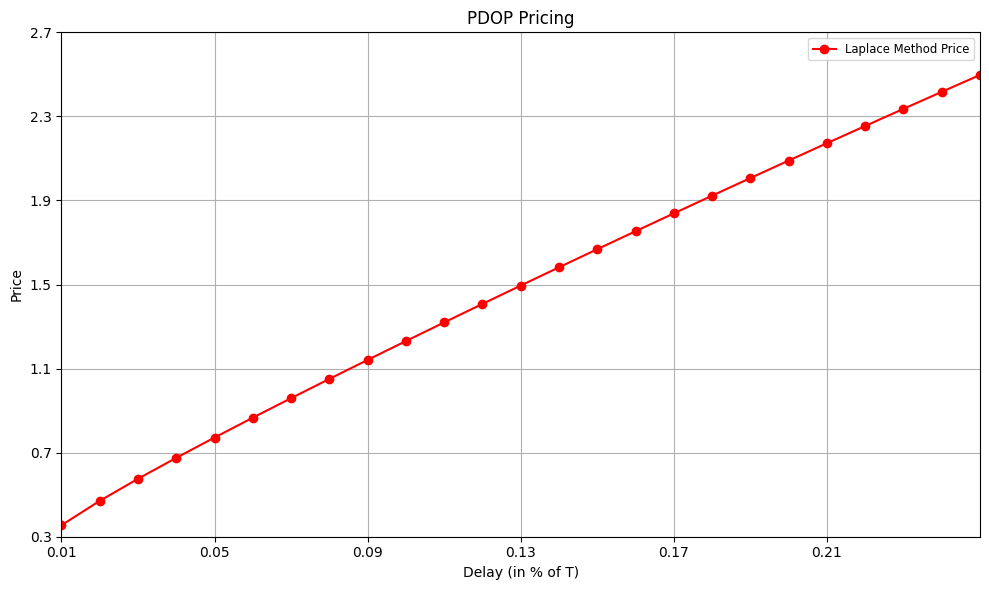

In [44]:
T_plot_prev = 1
(label_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot, ts_plot, n_paths_plot, delays_plot)  = (
    "PDOP", 100, 100, T_plot_prev, 90, 0.2, 0.025, 0, np.linspace(0, T_plot_prev, 500), 2**18, np.linspace(0.01, 0.25, 25))

plot_results(label_plot, ts_plot, n_paths_plot, delays_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot,methods = [Laplace_Pricing_function],
             brut_prices = True,plot_adaptative = False,CI = True, unique_price_simulation = False, proba=0.95)

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Global display for the three methods<h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

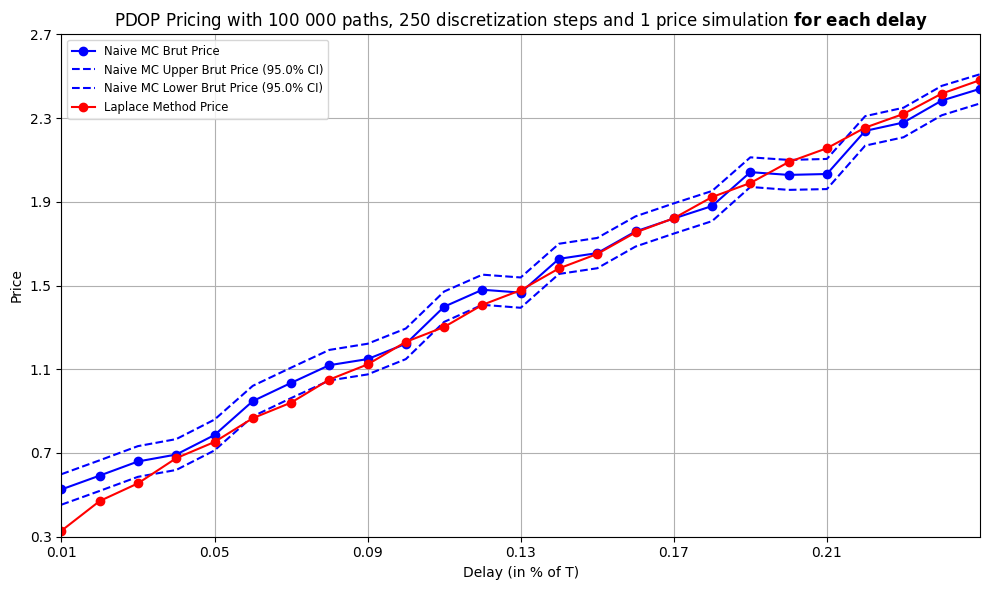

In [45]:
T_plot_prev = 1
(label_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot, ts_plot, n_paths_plot, delays_plot)  = (
    "PDOP", 100, 100, T_plot_prev, 90, 0.2, 0.025, 0, np.linspace(0, T_plot_prev, 250), 100000, np.linspace(0.01, 0.25, 25))

plot_results(label_plot, ts_plot, n_paths_plot, delays_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot,methods = [Naive_MC_Pricing_function, Laplace_Pricing_function],
             brut_prices = True,plot_adaptative = False,CI = True, unique_price_simulation = False, proba=0.95)

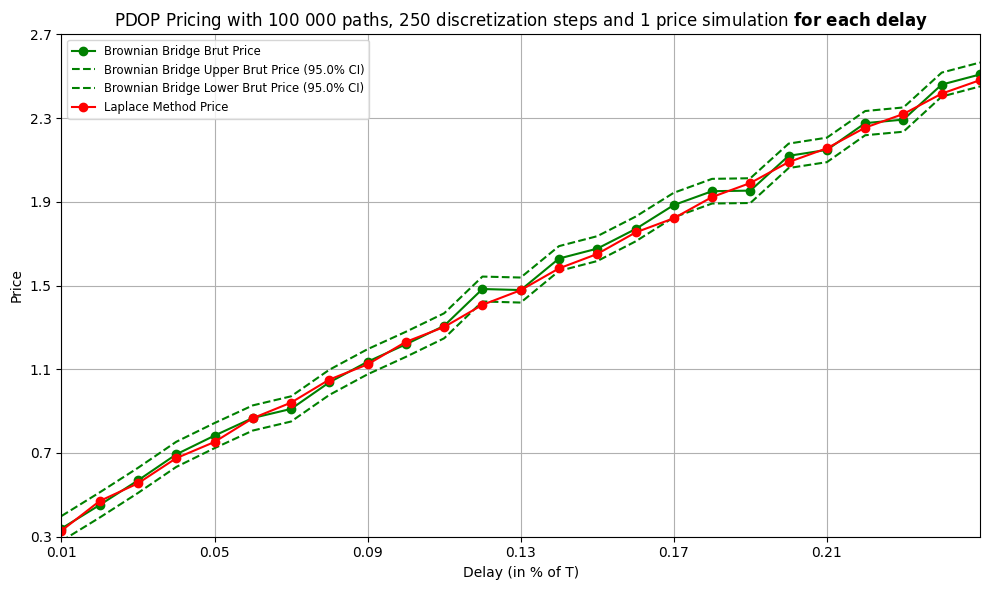

In [46]:
T_plot_prev = 1
(label_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot, ts_plot, n_paths_plot, delays_plot)  = (
    "PDOP", 100, 100, T_plot_prev, 90, 0.2, 0.025, 0, np.linspace(0, T_plot_prev, 250), 100000, np.linspace(0.01, 0.25, 25))

plot_results(label_plot, ts_plot, n_paths_plot, delays_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot,methods = [Brownian_Bridge_Pricing_function, Laplace_Pricing_function],
             brut_prices = True,plot_adaptative = False,CI = True, unique_price_simulation = False, proba=0.95)

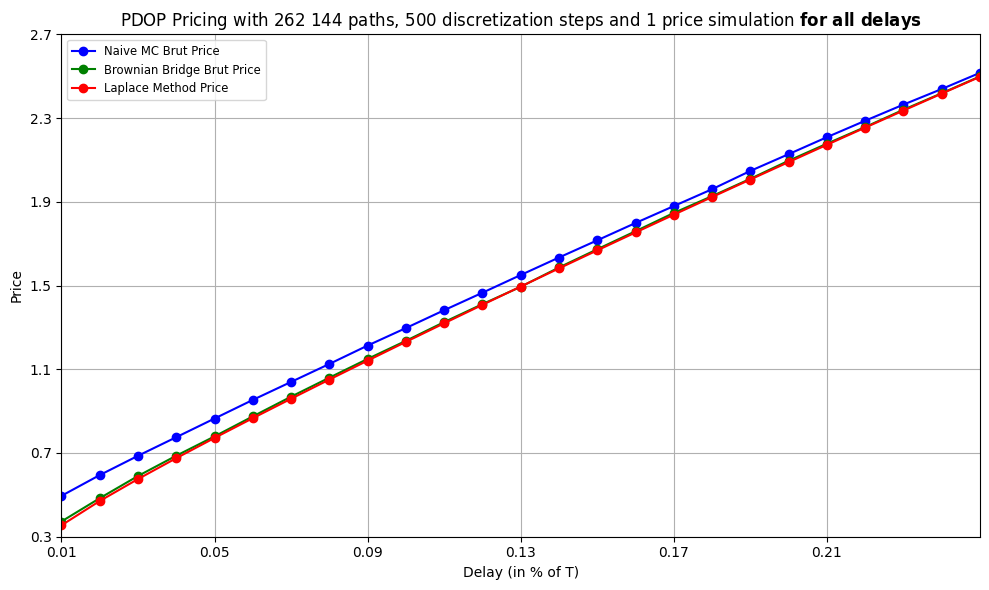

In [47]:
T_plot_prev = 1
(label_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot, ts_plot, n_paths_plot, delays_plot)  = (
    "PDOP", 100, 100, T_plot_prev, 90, 0.2, 0.025, 0, np.linspace(0, T_plot_prev, 500), 2**18, np.linspace(0.01, 0.25, 25))

plot_results(label_plot, ts_plot, n_paths_plot, delays_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot,methods = [Naive_MC_Pricing_function,Brownian_Bridge_Pricing_function, Laplace_Pricing_function],
             brut_prices = True,plot_adaptative = False,CI = False, unique_price_simulation = True, proba=0.95)

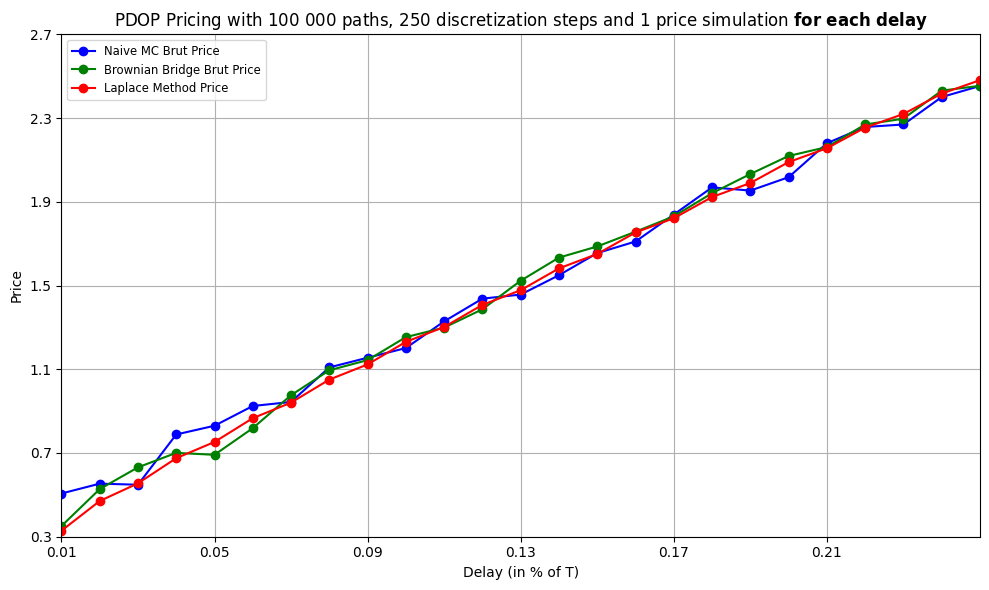

In [48]:
T_plot_prev = 1
(label_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot, ts_plot, n_paths_plot, delays_plot)  = (
    "PDOP", 100, 100, T_plot_prev, 90, 0.2, 0.025, 0, np.linspace(0, T_plot_prev, 250), 100000, np.linspace(0.01, 0.25, 25))

plot_results(label_plot, ts_plot, n_paths_plot, delays_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot,methods = [Naive_MC_Pricing_function,Brownian_Bridge_Pricing_function, Laplace_Pricing_function],
             brut_prices = True,plot_adaptative = False,CI = False, unique_price_simulation = False, proba=0.95)

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Variance Reduction<h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

**1. Theoretical approach**

We define $X$ and $X'$ that are identically distributed such that: 
$$
\mathbb{E}[X]=\mathbb{E}[X']=m_X,\quad
\mathrm{Var}[X]=\mathrm{Var}[X']=\sigma_X^2,
$$

but $\mathrm{Var}[X-X']>0$, and we set
$$
\Xi \;=\; X - X'.
$$

We introduce a dynamic control variate $\lambda$ and we set: 
$$
X^{\lambda} \;=\; X \;-\;\lambda\,\Xi,
$$

The variance of $X^{\lambda}$ is minimized when
$$
\lambda_{\min}
=\frac{\operatorname{Cov}(X,\Xi)}{\operatorname{Var}(\Xi)}.
$$

We compute the sample mean of the controlled payoffs, using an estimator $\hat\lambda_{min}$ for $\lambda_{min}$:

$$
\overline{X}_n^{\hat\lambda_{min}}
=\overline{X}_n + \hat\lambda^{min}_n\,\overline{\Xi}_n,
$$
where

$$
\overline{X}_n
=\frac{1}{n}\sum_{k=1}^n X_k,
\qquad
\hat\lambda^{min}_n
=\frac{\displaystyle\frac{1}{n}\sum_{k=1}^n X_k\,(X_k - X_k')}
     {\displaystyle\frac{1}{n}\sum_{k=1}^n (X_k - X_k')^2},
\qquad
\overline{\Xi}_n
=\frac{1}{n}\sum_{k=1}^n (X_k - X_k').
$$

We have: 

$$
\sqrt{n}\,\bigl(\overline{X}_n^{\hat\lambda_{min}}-m_X\bigr)
\;\xrightarrow{\mathcal{L}}\;
\mathcal{N}\bigl(0,\sigma^2_{\min}\bigr)
\quad\text{as }n\to+\infty,
$$
or equivalently
$$
\overline{X}_n^{\lambda}-m_X
\;\xrightarrow{\mathcal{L}}\;
\mathcal{N}\!\Bigl(0,\tfrac{\sigma^2_{\min}}{n}\Bigr)
\quad\text{as }n\to+\infty,
$$
with
$$
\sigma^2_{\min}\;\le\;\sigma_X^2.
$$

However our estimator 
$$
\mathbb{E}\bigl[\overline{X}_n^{\hat\lambda_{min}}\bigr]
= m_X \;-\; \mathbb{E}\bigl[\hat\lambda_n^{min}\,\overline{\Xi}_n\bigr].
$$
Indeed, in practice:
$$
\mathbb{E}\bigl[\hat\lambda_n^{min}\,\overline{\Xi}_n\bigr]\neq 0,
$$

To manage this issue, we use the adaptative approach. We define for each \(k\):
$$
\widetilde X_k \;=\; X_k \;-\;\widetilde\lambda_{k-1}\,\Xi_k,
$$
where
$$
\widetilde\lambda_k \;=\;\bigl(-k)\vee\bigl(\hat\lambda_n^{min}\wedge k\bigr),
$$

Our estimator is then:
$$
\overline{\widetilde X}_n
\;=\;\frac{1}{n}\sum_{k=1}^n \widetilde X_k
\;=\;\overline X_n
\;-\;\frac{1}{n}\sum_{k=1}^n\widetilde\lambda_{k-1}\,\Xi_k,
$$

This estimator satisfies (See G.~Pagès, Numerical Probability, §3.2.2):

- **Unbiasedness:** $\mathbb{E}\bigl[\overline{\widetilde X}_n\bigr]=m_X.$
- **Almost sure convergence:** $\overline{\widetilde X}_n \xrightarrow{\mathrm{a.s.}} m_X \quad\text{as }n\to+\infty.$
- **Asymptotic normality:** $\sqrt{n}\,\bigl(\overline{\widetilde X}_n - m_X\bigr) \xrightarrow{\mathcal{L}} \mathcal{N}\bigl(0,\sigma_{\min}^2\bigr) \quad\text{as }n\to+\infty.$
 
Then the adaptive estimator of $m$, defined by
$$
\widetilde X_M^{\lambda}
=\frac{1}{M}\sum_{k=1}^M\widetilde X_k,
$$
is unbiased 
$$
\mathbb{E}\bigl[\widetilde X_M^{\lambda}\bigr]=m,
$$
convergent, i.e.
$$
\widetilde X_M^{\lambda}\xrightarrow{\mathrm{a.s.}}m
\quad\text{as }M\to+\infty,
$$
and asymptotically normal with minimal variance, i.e.
$$
\sqrt{M}\,\bigl(\widetilde X_M^{\lambda}-m\bigr)
\xrightarrow{\mathcal{L}}
\mathcal{N}\bigl(0,\sigma_{\min}^2\bigr)
\quad\text{as }M\to+\infty.
$$

**2. Empirical application**

We perform only one simulation of $N\times M$ standard normal draws, corresponding to $N$ paths each discretized in $M$ steps.  

First, generate
$$
(W^i_j)_{%
  i=1,\dots,N,\; j=1,\dots,M}
\quad\text{drawn i.i.d with}\quad W^i_j\sim\mathcal{N}(0,1),
$$

and use these to build the price matrix $S_1$.  Then construct a second matrix $S_2$ by replacing each normal draw with its negation, $-W^i_j$.  The two matrices $S_1$ and $S_2$ are identically distributed, and combining their payoffs will reduce variance via antithetic pairing.

*Remark:* In the case of the Brownian bridge method, we simulate to compute the first payoff row
$$
(U^i_j)_{%
  i=1,\dots,N-1,\; j=1,\dots,M}
\quad\text{drawn i.i.d with}\quad U^i_j\sim\mathcal{U}([0,1]),
$$

and then we take $(1 - U^i_j)_{i=1,\dots,N-1,\; j=1,\dots,M}$ to simulate the second payoff row. 


For each path $i$ in $S_1$, apply the chosen Parisian pricing algorithm to obtain the non-discounted payoff
$$
X_{1}^i \;=\;\mathrm{Payoff}\bigl(S_1^{i},T\bigr),
$$
and similarly from $S_2$ obtain
$$
X_{2}^i \;=\;\mathrm{Payoff}\bigl(S_2^{i},T\bigr).
$$
Whenever the payoff uses the In–Out parity, remember to convert the Black–Scholes price into a time-$T$ cash flow by multiplying by $e^{rT}$ before forming $X_{1}^i$ or $X_{2}^i$.

We then form the adaptively antithetic combined payoff $\overline{X}$ such that: 

$$
\overline{X}_i
=X_{1}^i
\;-\;\hat\lambda^{\min}_{i-1}(X_{1}^i-X_{2}^i) 
$$


Finally, the option price is estimated by the discounted average of these adjusted payoffs:
$$
\widehat P
= e^{-rT}\,\frac1M\sum_{i=1}^{M}\overline{X}_i.
$$

### Function:

In [50]:
def adaptive_antithetic_pricer(label, S1, S2, S0, T, K, L, r, q, vol, delay, ts, n_paths, method, Unif=(0,0)):

    """
    Adaptive antithetic Monte Carlo pricer combining two sets of simulated paths.

    Notes
    -----
    - Reduces variance using adaptive control variate technique.
    - Compatible with both Classic MC and Brownian Bridge enhanced methods.
    - Automatically adjusts the optimal coefficient adaptively during the run.

    Parameters
    ----------
    label: str
        Name of the option type ("PUIC", "PDIC", etc.).
    S1: ndarray
        First set of simulated asset price paths.
    S2: ndarray
        Antithetic (mirror) set of asset price paths.
    S0: float
        Initial spot price of the underlying.
    T: float
        Time to maturity (in years).
    K: float
        Strike price.
    L: float
        Barrier level.
    r: float
        Risk-free interest rate.
    q: float
        Dividend yield.
    vol: float
        Volatility of the underlying.
    delay: int
        Minimum number of consecutive steps for barrier trigger.
    ts: array_like
        Array of time steps.
    n_paths: int
             Number of simulated paths.
    method: function
            Pricing function. 
    Unif: tuple, optionnal
          The matrix of uniforms for the Brownian Bridge approach. 

    Returns
    -------
    price: float
        Discounted Monte Carlo estimated price.
    var_estimator: float
        Estimated variance of the pricing estimator.
    """
    U1, U2 = Unif

    # Price each path set separately
    X1 = method (label, S1, S0, T, K, L, r, q, vol, delay, ts, n_paths, get_payoff = True, U = U1)
    X2 = method (label, S2, S0, T, K, L, r, q, vol, delay, ts, n_paths, get_payoff = True, U = U2)
    
    theta = X1 - X2 # Control variate term
    del S1, S2, X2, Unif # Free memory
    gc.collect()
    price, var_estimator = adaptive_antithetic_algo(X1, theta,r, T)
    
    del X1, theta # Clean up memory
    gc.collect()
    
    return price, var_estimator
    
@njit(cache=True)
def adaptive_antithetic_algo(X1, theta, r, T):

    """
    Core adaptive algorithm computing an antithetic control variate estimator.

    Notes
    -----
    - Accelerated with @njit(cache=True) to speed up iterative operations.
    - No parallelization since computations are sequentially dependent (adaptive update).
    - Online adaptation of the optimal control variate coefficient at each sample.

    Parameters
    ----------
    X1: ndarray
        Array of primary simulated payoffs.
    theta: ndarray
        Control variate (difference between original and antithetic payoffs).
    r: float
        Risk-free rate for discounting.
    T: float
        Time to maturity (in years).

    Returns
    -------
    price: float
        Final discounted price estimator.
    var_estimator: float
        Variance of the discounted estimator.
    """
    
    N = len(X1) # Number of samples
    estimator = np.zeros(N) # Running estimator array
    theta_sum = 0. # Cumulative sum of theta
    X1_sum = 0. # Cumulative sum of X1
    X1_theta_sum = 0. # Cumulative sum of X1 * theta
    theta_square_sum = 0  # Cumulative sum of theta^2
    lambda_batch = 0 # Batch estimation of lambda
    new_lambda_adaptative = 0. # Adaptive lambda updated online

    epsilon = 1e-8  # Numerical stability threshold

    # Initialize lambda adaptively based on first sample
    if abs(theta[0]) < 1e-8:
        previous_lambda_adaptative = 0.0
    else:
        previous_lambda_adaptative = X1[0] / theta[0]

    # Online update for each sample
    for j in range (0,N): 
        i=j+1 # Iteration count (starts at 1)

        # Update cumulative sums
        theta_sum+= theta[j]
        X1_sum+=X1[j]
        X1_theta_sum += X1[j]*theta[j]
        theta_square_sum += theta[j]**2

        # Update batch lambda estimate
        if theta_square_sum==0.: 
            lambda_batch=0.
        else : 
            lambda_batch= X1_theta_sum/theta_square_sum
        
        new_lambda_adaptative = np.maximum(np.minimum(i,lambda_batch),-i) # Clamp the adaptive lambda to avoid explosion
        
        estimator[j] =  X1_sum/i - previous_lambda_adaptative*theta_sum/i # Update estimator with current adaptive lambda
        previous_lambda_adaptative = new_lambda_adaptative # Prepare lambda for next iteration

    discount = np.exp(-r * T) # Discount final estimator
    return discount * estimator[-1], np.var(discount*estimator)

### Display:

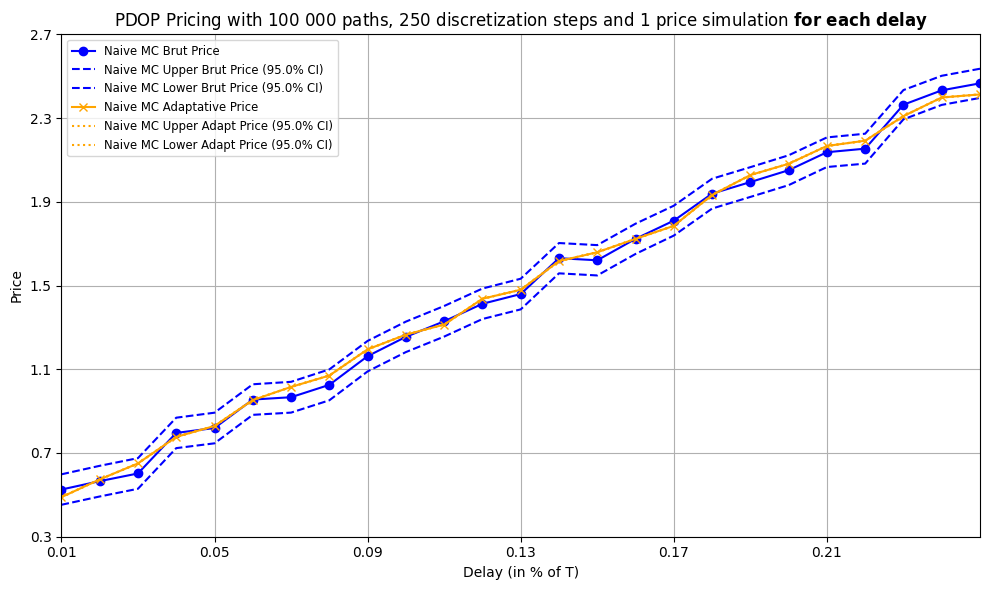

In [51]:
T_plot_prev = 1
(label_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot, ts_plot, n_paths_plot, delays_plot)  = (
    "PDOP", 100, 100, T_plot_prev, 90, 0.2, 0.025, 0, np.linspace(0, T_plot_prev, 250), 100000, np.linspace(0.01, 0.25, 25))

plot_results(label_plot, ts_plot, n_paths_plot, delays_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot,methods = [Naive_MC_Pricing_function],
             brut_prices = True,plot_adaptative = True,CI = True, unique_price_simulation = False, proba=0.95)

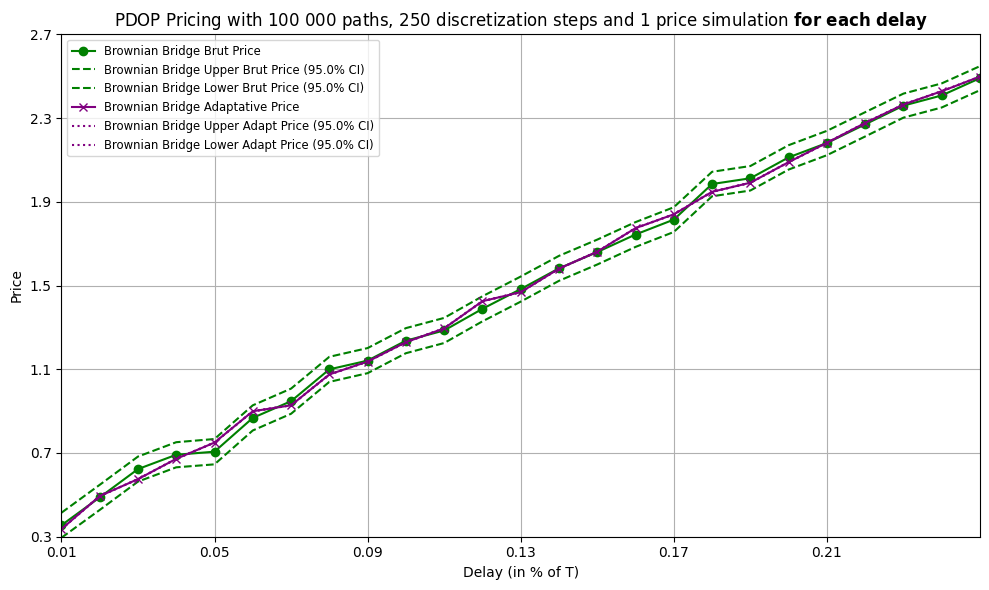

In [52]:
T_plot_prev = 1
(label_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot, ts_plot, n_paths_plot, delays_plot)  = (
    "PDOP", 100, 100, T_plot_prev, 90, 0.2, 0.025, 0, np.linspace(0, T_plot_prev, 250), 100000, np.linspace(0.01, 0.25, 25))

plot_results(label_plot, ts_plot, n_paths_plot, delays_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot,methods = [Brownian_Bridge_Pricing_function],
             brut_prices = True,plot_adaptative = True,CI = True, unique_price_simulation = False, proba=0.95)

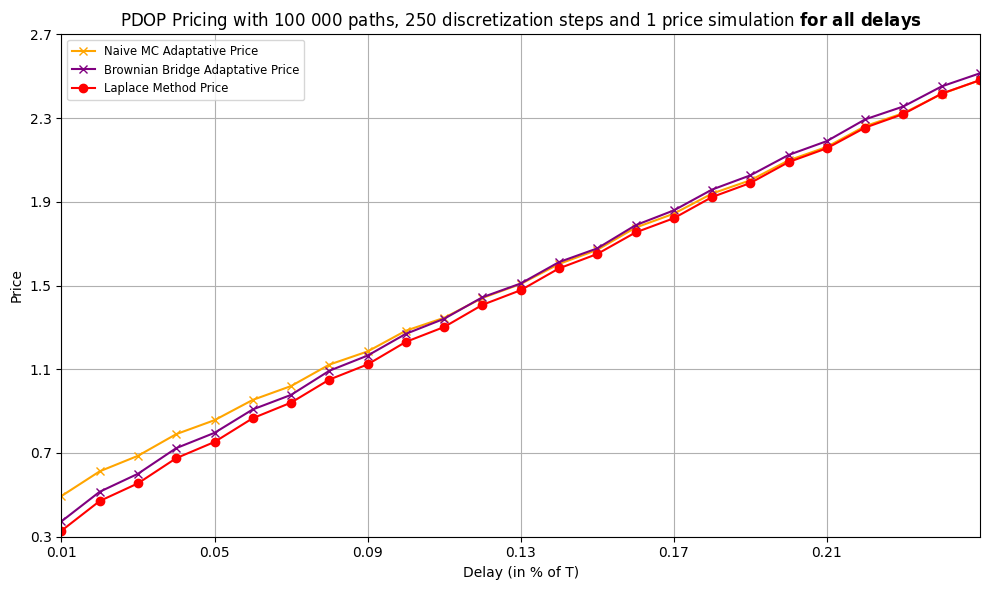

In [55]:
T_plot_prev = 1
(label_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot, ts_plot, n_paths_plot, delays_plot)  = (
    "PDOP", 100, 100, T_plot_prev, 90, 0.2, 0.025, 0, np.linspace(0, T_plot_prev, 250), 100000, np.linspace(0.01, 0.25, 25))

plot_results(label_plot, ts_plot, n_paths_plot, delays_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot,methods = [Naive_MC_Pricing_function,Brownian_Bridge_Pricing_function, Laplace_Pricing_function],
             brut_prices = False,plot_adaptative = True,CI = False, unique_price_simulation = True, proba=0.95)

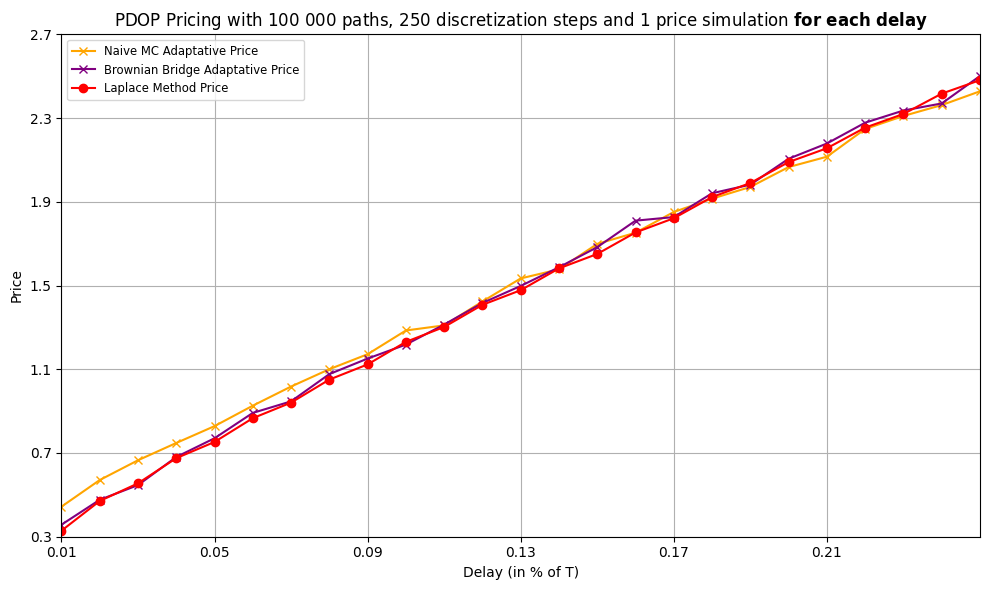

In [56]:
T_plot_prev = 1
(label_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot, ts_plot, n_paths_plot, delays_plot)  = (
    "PDOP", 100, 100, T_plot_prev, 90, 0.2, 0.025, 0, np.linspace(0, T_plot_prev, 250), 100000, np.linspace(0.01, 0.25, 25))

plot_results(label_plot, ts_plot, n_paths_plot, delays_plot, S0_plot, K_plot, T_plot, L_plot, vol_plot, r_plot, q_plot,methods = [Naive_MC_Pricing_function,Brownian_Bridge_Pricing_function, Laplace_Pricing_function],
             brut_prices = False,plot_adaptative = True,CI = False, unique_price_simulation = False, proba=0.95)

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Pandas Data Display<h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

### Display:

In [59]:
S0 = 100
K = 100
T = 1 
L = 90
vol = 0.2
r = 0.025
q = 0 
ts = np.linspace(0,T,500)
n_paths = 1000000
partial_delay = 0.13
dt = ts[1] - ts[0]
delay = int(np.round(partial_delay * T / dt))

S0

labels = [("PDIC","PDOC"), ("PUIC","PUOC"), ("PDIP","PDOP"), ("PUIP", "PUOP")]
methods = [Naive_MC_Pricing_function, Brownian_Bridge_Pricing_function,Laplace_Pricing_function]

display_results (ts,T, n_paths, S0, vol, r, q,L,delay,labels, methods, variance_reduction = False)

In [60]:
S0 = 100
K = 100
T = 1 
L = 90
vol = 0.2
r = 0.025
q = 0 
ts = np.linspace(0,T,500)
n_paths = 1000000
partial_delay = 0.13
dt = ts[1] - ts[0]
delay = int(np.round(partial_delay * T / dt))

labels = [("PDIC","PDOC"), ("PUIC","PUOC"), ("PDIP","PDOP"), ("PUIP", "PUOP")]
methods = [Naive_MC_Pricing_function, Brownian_Bridge_Pricing_function,Laplace_Pricing_function]

display_results (ts,T, n_paths, S0, vol, r, q,L,delay,labels, methods, variance_reduction = True)